In [24]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from  torch.distributions import normal , MultivariateNormal
import GPE_ensemble as GPE

dtype = torch.float
device = torch.device("cpu")

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


$y=f(x)+\epsilon$

$f(x)\sim GP(\mu, k)$

For some $y^*$ want to find $x^*$. Let $q(x)$ be a candidate distribution for $x^*$, in this case assume $q(x)\sim N(m,\Sigma)$.

Want to maximise the evidence lower bound (ELBO) with respect to $q$. 

To calibrate three model parameters we need to optimise over $m$ and and the 6 unique elements $\Sigma$ (9 parameters total).

$ELBO = \mathbb{E}_q[log(p(y,x))]-\mathbb{E}_q[log(q(x))] = \mathbb{E}_q[log(p(y|x)p(x)]-\mathbb{E}_q[log(q(x)]$

$= \int q(x)log(p(x)\Pi p(y_i|x))dx -\mathbb{E}_q[log(q(x))]dx$

$\approx \frac{1}{n}\sum log(p(x_j)\Pi p(y_i|x_j)) -\mathbb{E}_q[log(q(x))]$, $x_i$ sampled from $q$.

$\mathbb{E}_q[log(q(x))] = -\frac{3}{2}(1+log(2\pi)) -\frac{1}{2}log(det(\Sigma))$

Log likelihood
$y=f(x)+\epsilon$

$f|x \sim N(\mu(x), k(x,x))$

$y|x \sim N(\mu(x),\sigma^2 + k(x,x))$

$log p(y|x) \propto -\frac{1}{2}log(\sigma^2 + k(x,x))-\frac{1}{2(\sigma^2 + k(x,x))}(y-\mu(x))^2$ 

So what we want is:

$log p(y|x) \propto -\frac{1}{2}log(\sigma^2 + k(x,x))-\frac{1}{2(\sigma^2 + k(x,x))}(y-\mu(x))^2$ 

and what I'm currently using is

$log p(f|x) \propto -\frac{1}{2}log(k(x,x))-\frac{1}{2(k(x,x))}(y-\mu(x))^2$

# $y=-a(x-b)^2+c$

In [25]:
dtype = torch.float32
device = torch.device("cpu")

In [42]:
def ELBO(m,s2,x,emulator,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    L=L.diagonal_scatter(s2)
    
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
    
    z=z.T 
    
    mc_int = (emulator.ensemble_log_likelihood_obs_error(z,y,obs_error)+x_prior(z,prior_mean,prior_cov)[:,None]).mean()
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int - q_prior(covar)
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb
    

def ELBO_fun(m,s2,x,function,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    L=L.diagonal_scatter(s2)
    
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
   
    z=z.T 
    
    mc_int = (f_likelihood(z,y,function,obs_error)+x_prior(z,prior_mean,prior_cov)[:,None]).mean()
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int - q_prior(covar)
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb

def x_prior(x,mean,cov):

    #var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    #val1 = var.pdf(x)
    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    val = dist.log_prob(x)
    return val

def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+torch.log(torch.tensor(2*torch.pi)))-0.5*torch.log(torch.linalg.det(covar))
    return qp

def f_likelihood(x,y,f,sigma2):
    #x,f=emulator.normalise_test_data(x,f(x))
    #x,y=emulator.normalise_test_data(x,y)
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*torch.log(torch.tensor(2*np.pi))-0.5*torch.log(sigma2)
    return likelihood_manual

def f_likelihood2(x,y,f,sigma2):
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*np.log(2*np.pi)-0.5*np.log(sigma2)
    return likelihood_manual

In [43]:
p=5

In [44]:
rl = -10
ru=20

In [45]:
obs_error = [0.001]

In [46]:
x=torch.linspace(rl,ru,p)

In [47]:
x

tensor([-10.0000,  -2.5000,   5.0000,  12.5000,  20.0000])

In [48]:
a=0.05
b=5
c=1

In [49]:
def quad(x):
    y = - a*(x-c)**2 +b
    return y

In [50]:
y = quad(x) #+ torch.random.normal(0,obs_error,p)

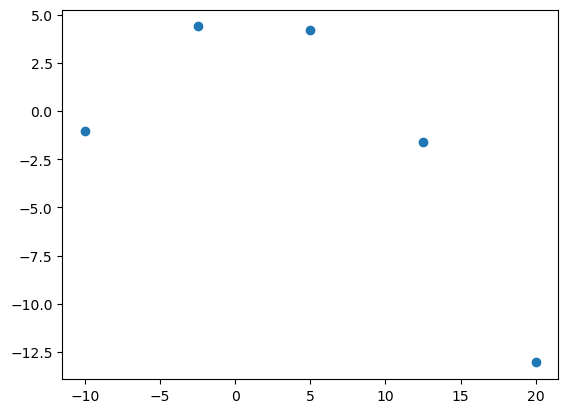

In [51]:
plt.plot(x,y,'o')

In [52]:
emulator = GPE.ensemble(x[:,None],y[:,None],mean_func="constant",training_iter=500)

0


In [53]:
tp = 500
dx = (ru-rl)/tp
x_test = torch.linspace(rl,ru,tp)


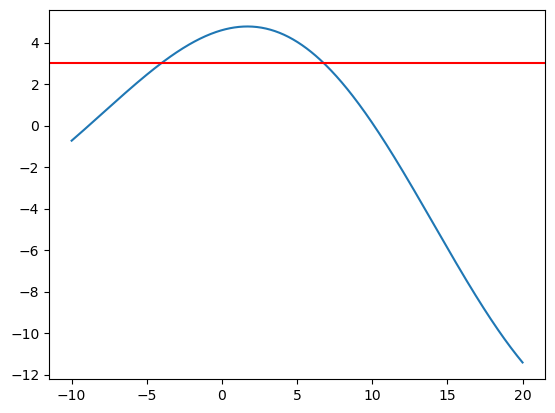

In [54]:
plt.plot(x_test,emulator.predict(x_test).detach().numpy())
plt.axhline(y=3, color='r', linestyle='-')

In [55]:
emulator.training_output_STD

tensor([7.0842])

In [56]:
prior_mean=torch.tensor([0])
prior_cov = torch.tensor([10])*torch.eye(1)
obs_error = torch.tensor([0.1])
y_cal = torch.tensor([3])

In [57]:
### initialize the variational parameters
m = torch.full((), 1.,dtype=dtype, requires_grad=True, device=device)
s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(1000):
    Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
    Z=Z[None,:]
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    if t % 100 == 99:
        print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        m -= learning_rate * m.grad
        s2 -= learning_rate * s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        s2.grad = None
        
print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

99 2.1799850463867188 m= 0.9018296003341675 s2= 9.228748321533203
199 2.1683175563812256 m= 0.8120414614677429 s2= 9.405876159667969
299 2.1345102787017822 m= 0.7299266457557678 s2= 9.531110763549805
399 2.1146240234375 m= 0.6570680737495422 s2= 9.659141540527344
499 2.151320695877075 m= 0.588996410369873 s2= 9.742155075073242
599 2.1371774673461914 m= 0.5281900763511658 s2= 9.814764022827148
699 2.130584239959717 m= 0.4710843861103058 s2= 9.878220558166504
799 2.1360788345336914 m= 0.4215708076953888 s2= 9.92545223236084
899 2.1413607597351074 m= 0.3779243528842926 s2= 9.956141471862793
999 2.133481740951538 m= 0.3363664448261261 s2= 9.995570182800293
Result: p(x|y) = N(0.33585864305496216, 9.995674133300781) 


In [58]:
### initialize the variational parameters
m_fun = torch.full((), 0.,dtype=dtype, requires_grad=True, device=device)
s2_fun = torch.full((1,),1,dtype=dtype, requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(1000):
    Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
    Z=Z[None,:]
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO_fun(m_fun,s2_fun,Z,quad,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    if t % 100 == 99:
        print(t, negELBO.item(), 'm=', m_fun.item(), 's2=', s2_fun.pow(2).item())
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        m_fun -= learning_rate * m_fun.grad
        s2_fun -= learning_rate * s2_fun.grad
        #print(m_fun.grad)
        #print(s2_fun.grad)
        # Manually zero the gradients after updating weights
        m_fun.grad = None
        s2_fun.grad = None
        
print(f'Result: p(x|y) = N({m_fun.item()}, {torch.pow(s2_fun,2).item()}) ')

99 11.915410995483398 m= -1.9571125507354736 s2= 6.101363182067871
199 4.789216041564941 m= -4.087250709533691 s2= 1.296097993850708
299 2.945713520050049 m= -5.074049949645996 s2= 0.2760073244571686
399 2.9378108978271484 m= -5.127015113830566 s2= 0.2708669602870941
499 2.9558377265930176 m= -5.125034332275391 s2= 0.26548922061920166
599 2.9602346420288086 m= -5.122088432312012 s2= 0.26578763127326965
699 2.9538309574127197 m= -5.124828338623047 s2= 0.26485294103622437
799 2.9794089794158936 m= -5.125864505767822 s2= 0.26820436120033264
899 2.9954490661621094 m= -5.125682830810547 s2= 0.26619383692741394
999 2.9446218013763428 m= -5.126271724700928 s2= 0.26041513681411743
Result: p(x|y) = N(-5.126753330230713, 0.26197803020477295) 


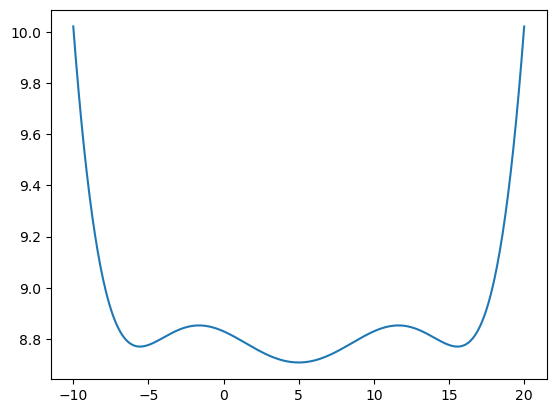

In [59]:
plt.plot(x_test,emulator.generate_variance(x_test).detach().numpy().squeeze())

In [60]:
x_n,x_n1 = emulator.normalise_test_data(x_test,x_test)
c_n = emulator.likelihoods[0](emulator.models[0](x_n)).covariance_matrix

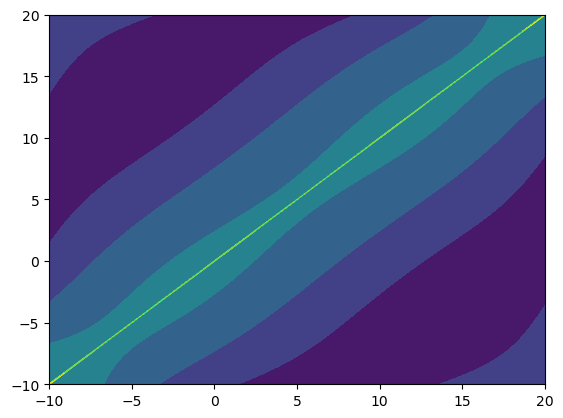

In [61]:
plt.contourf(x_test,x_test,c_n.detach().numpy())

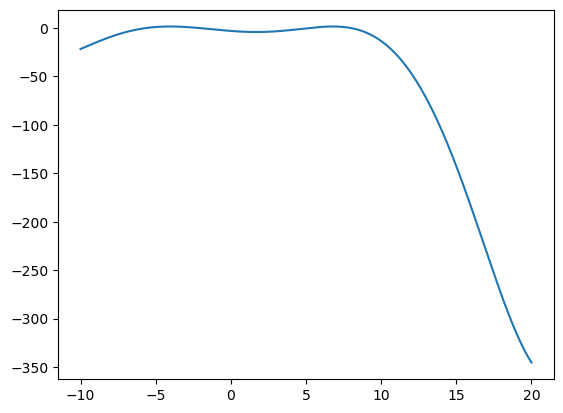

In [62]:
like=(-0.5*((emulator.predict(x_test)-y_cal)**2)/(obs_error+c_n.diag()[:,None])-0.5*torch.log(obs_error+c_n.diag()[:,None])-- 0.5*torch.log(torch.tensor(2*np.pi))).detach().numpy()
plt.plot(x_test,like)

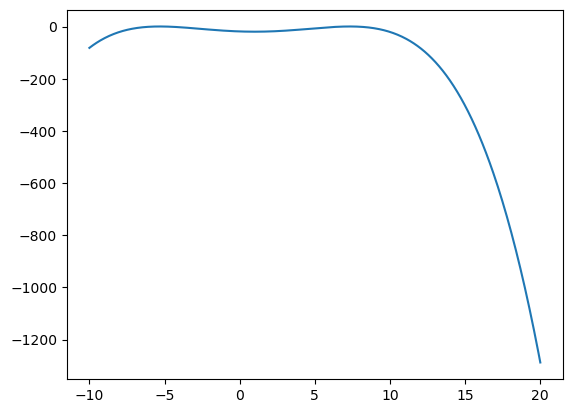

In [63]:
like = -0.5*(quad(x_test)-y_cal)**2/obs_error-0.5*np.log(obs_error)- 0.5*torch.log(torch.tensor(2*np.pi))
plt.plot(x_test,like)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_14325/3715141962.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  plt.plot(f_likelihood(x_test,y_cal,quad,obs_error).T)


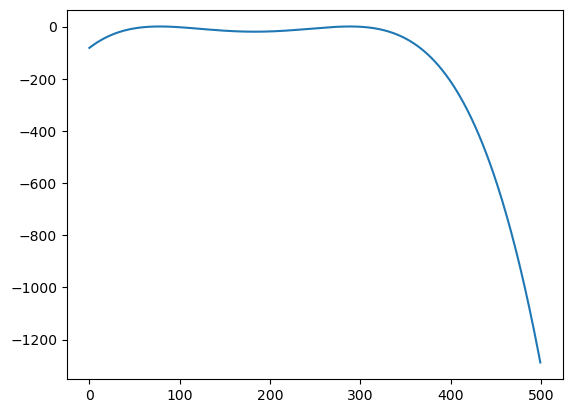

In [64]:
plt.plot(f_likelihood(x_test,y_cal,quad,obs_error).T)

In [65]:
f_likelihood(x_test,y_cal,quad,obs_error).T.mean()

tensor(-149.6062)

In [66]:
emulator.normalise_test_data(torch.tensor([1.1]),torch.tensor([1]))

(tensor([-0.3289]), tensor([0.3423]))

In [67]:
emulator.normalise_test_data(torch.tensor([-1]),torch.tensor([0]))

(tensor([-0.5060]), tensor([0.2012]))

In [68]:
torch.sum(f_likelihood(x_test,y_cal,quad,obs_error))

tensor(-74803.0781)

In [69]:
torch.sum(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error))

tensor(-1873.3379, grad_fn=<SumBackward0>)

In [70]:
emulator.likelihoods[0](emulator.models[0](Z.T)).covariance_matrix.diag()

tensor([0.1764, 0.1764, 0.4010, 0.1760, 0.2447, 0.1782, 0.1828, 0.1762, 0.1747,
        0.3709, 0.6894, 0.1742, 0.1762, 0.1874, 0.1759, 0.1750, 0.3090, 0.1764,
        0.1755, 0.1805, 0.2031, 0.1764, 0.1749, 0.1763, 0.1764, 0.1736, 0.1748,
        0.2963, 0.1764, 0.2389, 0.1823, 0.4123, 0.1763, 0.1735, 0.1760, 0.1737,
        0.1750, 0.1845, 0.1757, 0.1754, 0.1743, 0.1745, 0.2533, 0.1751, 0.1745,
        0.3426, 0.1780, 0.1761, 0.1760, 0.1756, 0.1772, 0.1737, 0.1895, 0.1764,
        0.1751, 0.1746, 0.1762, 0.1740, 0.1764, 0.1760, 1.0841, 0.1761, 0.1744,
        0.3342, 0.1751, 0.1737, 0.2126, 0.1759, 0.6672, 0.1735, 0.1735, 0.1762,
        0.1750, 0.1791, 0.3859, 0.1763, 0.1740, 0.1764, 0.1739, 1.3638, 0.1760,
        0.1760, 0.1752, 0.1741, 0.1763, 0.1754, 0.1793, 0.2012, 0.2018, 0.1758,
        0.1759, 0.8481, 0.1738, 0.1755, 0.3715, 0.1757, 0.1750, 0.1764, 0.1762,
        0.1749, 0.3102, 0.1749, 0.1800, 0.1764, 0.1739, 0.2324, 0.1756, 0.1760,
        0.1739, 0.1758, 0.1768, 0.1737, 

In [71]:
dist = normal.Normal(loc=m_fun, scale=s2_fun)
val = torch.exp(dist.log_prob(x_test))

In [72]:
likelihood = torch.exp(emulator.ensemble_log_likelihood_obs_error_no_U(x_test,y_cal[:,None],obs_error))

In [73]:
prior_mean

tensor([0])

In [74]:
dist_prior = normal.Normal(loc=prior_mean, scale=torch.sqrt(torch.tensor([5])))
val_prior = torch.exp(dist_prior.log_prob(x_test))

In [75]:
posterior = likelihood*val_prior / (torch.sum(likelihood*val_prior)*dx)

In [76]:
true_likelihood= (f_likelihood(x_test,y_cal,quad,obs_error))

In [77]:
true_likelihood=torch.exp(true_likelihood)

In [78]:
true_posterior = true_likelihood.squeeze()*val_prior / (torch.sum(true_likelihood.squeeze()*val_prior)*dx)

In [79]:
true_likelihood2= np.array(f_likelihood2(x_test,y_cal,quad,obs_error))

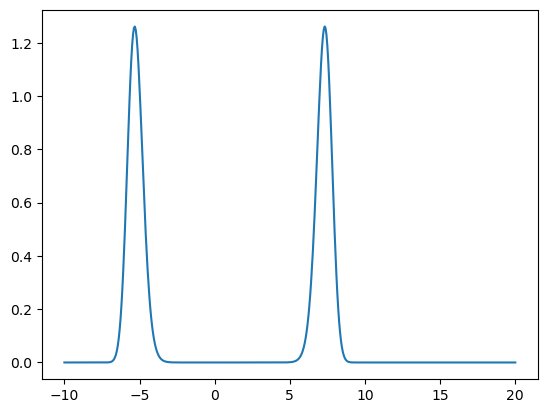

In [80]:
plt.plot(x_test.detach().numpy(),np.exp(true_likelihood2))

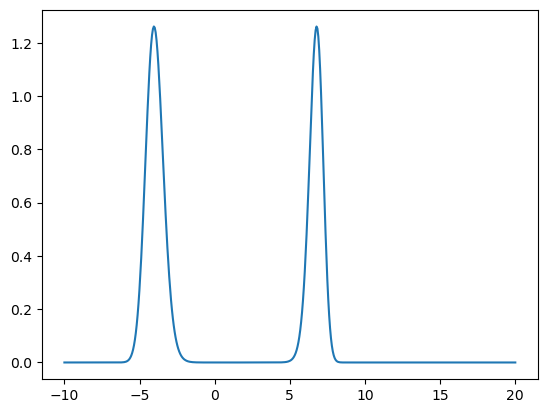

In [81]:
plt.plot(x_test.detach().numpy(),(likelihood).detach().numpy().squeeze())

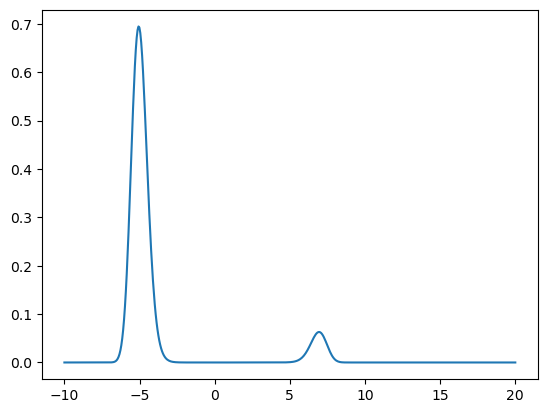

In [82]:
plt.plot(x_test.detach().numpy(),true_posterior.T.detach().numpy())

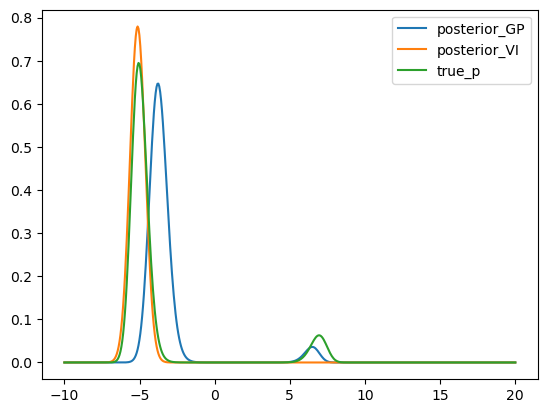

In [83]:
plt.plot(x_test.detach().numpy(),posterior.detach().numpy().T)
plt.plot(x_test.detach().numpy(),val.detach().numpy())
plt.plot(x_test.detach().numpy(),true_posterior.detach().numpy().T)
plt.legend(['posterior_GP','posterior_VI','true_p'])

In [84]:
obs_errors = torch.tensor([1,0.5,0.1,0.05,0.01])
posterior_GPE = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_VI = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_VI_fun = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_True = torch.zeros((x_test.shape[0],obs_errors.shape[0]))

In [85]:
for j,obs_error in enumerate(obs_errors):
    #result = minimize(ELBO, [1,1], args = (xx,emulator,y_test,prior_mean,prior_covar,x.columns,obs_error),method = 'Nelder-Mead',tol=1e-6)
    #var = scipy.stats.multivariate_normal(mean=(result.x[0]), cov=result.x[1]**2)
    #posterior_VI[:,j] = var.pdf(x_test)
    
    ### initialize the variational parameters
    m = torch.full((), 0.,dtype=dtype, requires_grad=True, device=device)
    s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)
    obs_error=torch.tensor([obs_error])
    print(obs_error.shape)
    # Samples fixed here - but try adding them into the loop
    nsamples = 1000
    #Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

    learning_rate = 1e-2
    for t in range(5000):
        Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
        Z=Z[None,:]
        #negELBO = -Eloglike(m,log_s2)+KL(log_s2)

        #negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
        negELBO = ELBO_fun(m,s2,Z,quad,y_cal[:,None],prior_mean,prior_cov,obs_error)
        if t % 100 == 99:
            print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.item())

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
        # the gradient of the loss with respect to a, b, c, d respectively.
        negELBO.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            m -= learning_rate * m.grad
            s2 -= learning_rate * s2.grad

            # Manually zero the gradients after updating weights
            m.grad = None
            s2.grad = None

    print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')
    
    dist = normal.Normal(loc=m, scale=s2)
    posterior_VI_fun[:,j] = torch.exp(dist.log_prob(x_test))
    
    ### initialize the variational parameters
    m = torch.full((), 0.,dtype=dtype, requires_grad=True, device=device)
    s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)
    
    for t in range(5000):
        Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
        Z=Z[None,:]
        #negELBO = -Eloglike(m,log_s2)+KL(log_s2)

        negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
        #negELBO = ELBO_fun(m,s2,Z,quad,y_cal[:,None],prior_mean,prior_cov,obs_error)
        if t % 100 == 99:
            print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.item())

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
        # the gradient of the loss with respect to a, b, c, d respectively.
        negELBO.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            m -= learning_rate * m.grad
            s2 -= learning_rate * s2.grad

            # Manually zero the gradients after updating weights
            m.grad = None
            s2.grad = None

    print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')
    
    dist = normal.Normal(loc=m, scale=s2)
    posterior_VI[:,j] = torch.exp(dist.log_prob(x_test))
    
    likelihood = torch.prod(torch.exp(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error)),axis=0)
    posterior_GPE[:,j] = likelihood*val_prior / (torch.sum(likelihood*val_prior)*dx)
    
    true_likelihood= f_likelihood(x_test,y_cal,quad,obs_error)
    true_likelihood=torch.exp(true_likelihood)
    posterior_True[:,j] = (true_likelihood.squeeze()*val_prior / (torch.sum(true_likelihood.squeeze()*val_prior)*dx)).T
    
    print(j)
    
    

torch.Size([1])
99 2.2761731147766113 m= -0.051399458199739456 s2= 3.1476263999938965
199 2.208374500274658 m= -0.08874522149562836 s2= 3.2399566173553467
299 2.230926513671875 m= -0.1145286113023758 s2= 3.2903480529785156
399 2.2159605026245117 m= -0.13647596538066864 s2= 3.3199222087860107
499 2.211514949798584 m= -0.15156389772891998 s2= 3.3280694484710693
599 2.207296848297119 m= -0.16383138298988342 s2= 3.3300414085388184
699 2.316516876220703 m= -0.17566163837909698 s2= 3.335080862045288
799 2.217867851257324 m= -0.18715247511863708 s2= 3.3393774032592773
899 2.1992502212524414 m= -0.1976439505815506 s2= 3.338771343231201
999 2.2859973907470703 m= -0.20648513734340668 s2= 3.3396472930908203
1099 2.2513504028320312 m= -0.21737444400787354 s2= 3.3403830528259277
1199 2.269343852996826 m= -0.22245801985263824 s2= 3.3361549377441406
1299 2.2523679733276367 m= -0.2300349920988083 s2= 3.331155300140381
1399 2.295740842819214 m= -0.2368297278881073 s2= 3.3323159217834473
1499 2.30137705

2399 3.345818519592285 m= -0.7718719840049744 s2= 3.199953317642212
2499 3.162374973297119 m= -0.8052732944488525 s2= 3.180189371109009
2599 3.272531032562256 m= -0.8420602083206177 s2= 3.17160964012146
2699 3.1991777420043945 m= -0.8763540387153625 s2= 3.157118558883667
2799 3.1441338062286377 m= -0.9124370813369751 s2= 3.137193202972412
2899 3.2308497428894043 m= -0.9557200074195862 s2= 3.1316704750061035
2999 3.1950061321258545 m= -0.9941424131393433 s2= 3.111978054046631
3099 3.100449800491333 m= -1.0366677045822144 s2= 3.100353956222534
3199 3.1999568939208984 m= -1.0800843238830566 s2= 3.080291986465454
3299 3.166137456893921 m= -1.1252470016479492 s2= 3.06050443649292
3399 3.3275861740112305 m= -1.169996738433838 s2= 3.0313093662261963
3499 3.098689079284668 m= -1.220108151435852 s2= 3.0057921409606934
3599 3.2418317794799805 m= -1.2749791145324707 s2= 2.986220121383667
3699 3.370102882385254 m= -1.3318986892700195 s2= 2.9534308910369873
3799 3.252643346786499 m= -1.393366456031

4799 2.9538817405700684 m= -5.129668235778809 s2= 0.5158389210700989
4899 2.9819700717926025 m= -5.129261493682861 s2= 0.5192593336105347
4999 2.971177577972412 m= -5.126610279083252 s2= 0.5145777463912964
Result: p(x|y) = N(-5.126438140869141, 0.26469776034355164) 
99 2.1157870292663574 m= -0.006236474495381117 s2= 3.0352823734283447
199 2.1112122535705566 m= -0.011059018783271313 s2= 3.061123847961426
299 2.097778558731079 m= -0.015181213617324829 s2= 3.078859806060791
399 2.144141674041748 m= -0.020797578617930412 s2= 3.095762252807617
499 2.1409430503845215 m= -0.0252866018563509 s2= 3.1100833415985107
599 2.09963321685791 m= -0.027571124956011772 s2= 3.1186602115631104
699 2.121527671813965 m= -0.031326774507761 s2= 3.1283445358276367
799 2.0935683250427246 m= -0.03303954005241394 s2= 3.1354362964630127
899 2.117326259613037 m= -0.03490053862333298 s2= 3.1411514282226562
999 2.1349167823791504 m= -0.03773224353790283 s2= 3.1468141078948975
1099 2.1164655685424805 m= -0.03987230733

1399 2.1415908336639404 m= -0.042992979288101196 s2= 3.1544978618621826
1499 2.0722410678863525 m= -0.04313759505748749 s2= 3.157477617263794
1599 2.109140634536743 m= -0.04406082630157471 s2= 3.1573524475097656
1699 2.1214568614959717 m= -0.04413820803165436 s2= 3.1586086750030518
1799 2.114015579223633 m= -0.04511575773358345 s2= 3.159388303756714
1899 2.1022982597351074 m= -0.045751795172691345 s2= 3.159248113632202
1999 2.128567695617676 m= -0.04608003795146942 s2= 3.158963441848755
2099 2.13175106048584 m= -0.047681860625743866 s2= 3.159538984298706
2199 2.1618618965148926 m= -0.046279426664114 s2= 3.1598093509674072
2299 2.1374011039733887 m= -0.04767504334449768 s2= 3.1597018241882324
2399 2.124927520751953 m= -0.04831855371594429 s2= 3.1616339683532715
2499 2.1181259155273438 m= -0.04915222153067589 s2= 3.159440279006958
2599 2.093193531036377 m= -0.05008861422538757 s2= 3.1602766513824463
2699 2.0754623413085938 m= -0.051200538873672485 s2= 3.16102933883667
2799 2.088258266448

2999 2.1037399768829346 m= -0.054078370332717896 s2= 3.157841920852661
3099 2.1417126655578613 m= -0.05218692496418953 s2= 3.156198501586914
3199 2.128293037414551 m= -0.053177233785390854 s2= 3.155226469039917
3299 2.117414951324463 m= -0.054297883063554764 s2= 3.1542749404907227
3399 2.102313756942749 m= -0.05420332029461861 s2= 3.1545746326446533
3499 2.1453614234924316 m= -0.05399848148226738 s2= 3.1579787731170654
3599 2.1078872680664062 m= -0.05503326654434204 s2= 3.1590020656585693
3699 2.121184825897217 m= -0.05583740770816803 s2= 3.160341262817383
3799 2.1018269062042236 m= -0.05647393316030502 s2= 3.160191774368286
3899 2.121157646179199 m= -0.05587122216820717 s2= 3.159395456314087
3999 2.1018691062927246 m= -0.056418031454086304 s2= 3.1596081256866455
4099 2.118664264678955 m= -0.055897295475006104 s2= 3.161064863204956
4199 2.1151156425476074 m= -0.055842213332653046 s2= 3.160005807876587
4299 2.1138787269592285 m= -0.05480394884943962 s2= 3.1580545902252197
4399 2.0959417

In [86]:
obs_error

tensor([0.0100])

In [87]:
l = obs_errors.tolist()
l.append('prior')

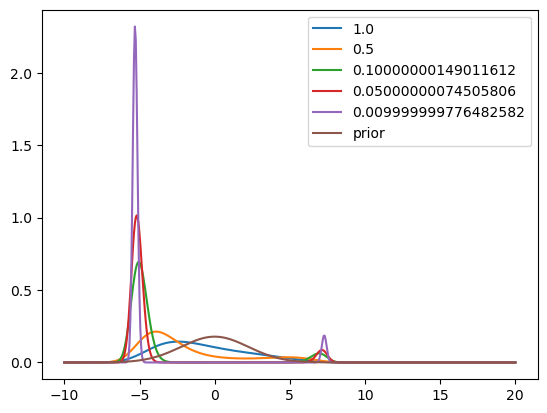

In [88]:
plt.plot(x_test.detach().numpy(),posterior_True.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

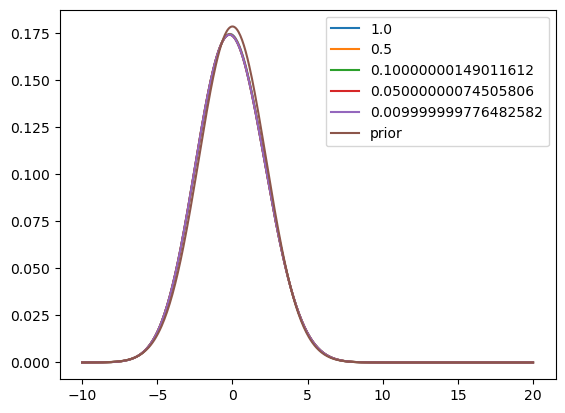

In [89]:
plt.plot(x_test.detach().numpy(),posterior_GPE.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

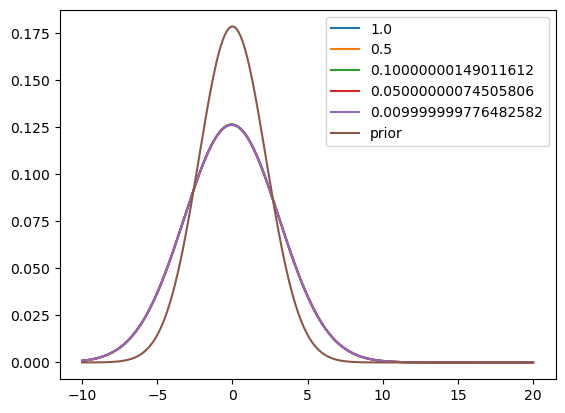

In [90]:
plt.plot(x_test.detach().numpy(),posterior_VI.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

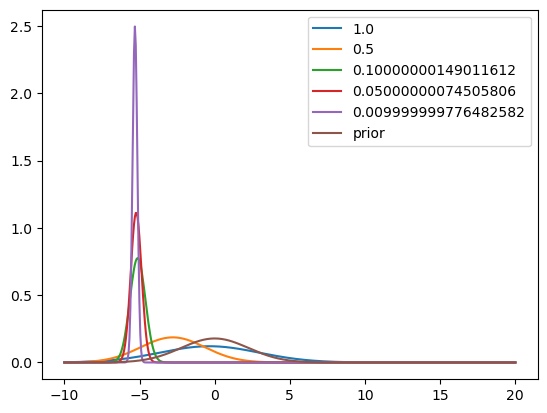

In [91]:
plt.plot(x_test.detach().numpy(),posterior_VI_fun.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

# $y=bx$

$y=bx+\epsilon$

$y|x \sim N(bx,\sigma^2)$

$x \sim N(\mu_0,\sigma_0^2)$

Then

$x|y \sim N(\mu_p,\sigma_p^2)$

where

$\mu_p = \frac{\sigma_0^2by+\sigma^2\mu_0}{\sigma_0^2b^2+\sigma^2}$

and

$\sigma_p^2 = \frac{2\sigma_0^2\sigma^2}{\sigma_0^2b^2+\sigma^2}$

In [92]:
p=10

In [93]:
rl = -10
ru=20

In [94]:
obs_error = 0.001

In [95]:
x=torch.linspace(rl,ru,p)

In [96]:
b=0.5

In [97]:
def lin(x):
    y = b*x
    return y

In [98]:
y = lin(x) 

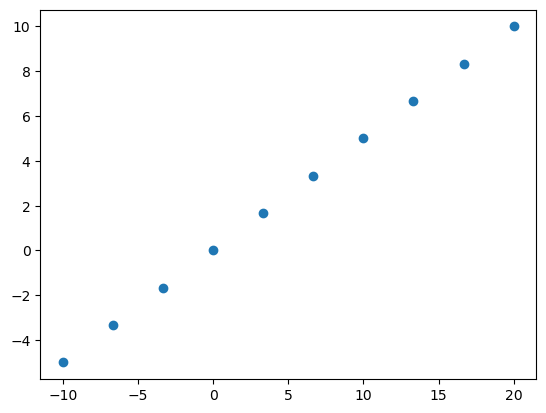

In [99]:
plt.plot(x.detach().numpy(),y.detach().numpy(),'o')

In [100]:
emulator = GPE.ensemble(x[:,None],y[:,None],mean_func="linear",training_iter=500)

0


In [101]:
tp = 500
dx = (ru-rl)/tp
x_test = torch.linspace(ru,rl,tp)


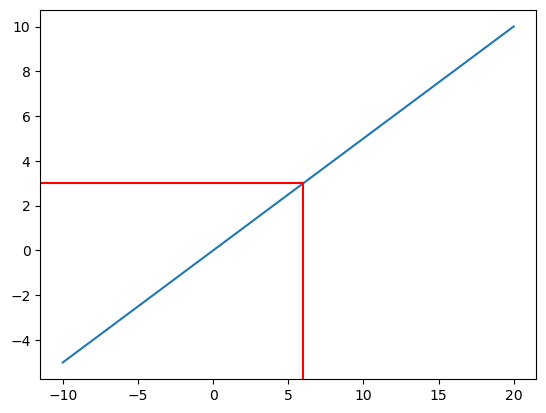

In [102]:
plt.plot(x_test,emulator.predict(x_test).detach().numpy())
plt.axhline(y=3, color='r', linestyle='-',xmax=0.53)
plt.axvline(x=6, color='r', linestyle='-',ymax=0.53)

In [103]:
prior_mean=torch.tensor([0])
prior_cov = torch.tensor([1])*torch.eye(1)
obs_error = torch.tensor([0.001])
y_cal = torch.tensor([3])

In [104]:
### initialize the variational parameters
m = torch.full((), 1.,dtype=dtype, requires_grad=True, device=device)
s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(1000):
    Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
    Z=Z[None,:]
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    if t % 100 == 99:
        print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():
        m -= learning_rate * m.grad
        s2 -= learning_rate * s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        s2.grad = None
        
print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

99 17.948047637939453 m= 5.918702602386475 s2= 0.015910089015960693
199 17.959104537963867 m= 5.9113311767578125 s2= 0.013088618405163288
299 18.017009735107422 m= 5.912961483001709 s2= 0.013985472731292248
399 17.92459487915039 m= 5.910389423370361 s2= 0.01364772580564022
499 17.993228912353516 m= 5.914210319519043 s2= 0.013280793093144894
599 17.975006103515625 m= 5.913341045379639 s2= 0.015028504654765129
699 18.01263999938965 m= 5.914668560028076 s2= 0.015457437373697758
799 17.92483139038086 m= 5.910852909088135 s2= 0.01356443203985691
899 17.980449676513672 m= 5.914434432983398 s2= 0.015388677828013897
999 17.98011589050293 m= 5.916572093963623 s2= 0.015269420109689236
Result: p(x|y) = N(5.91287088394165, 0.01378199364989996) 


In [105]:
dist = normal.Normal(loc=m, scale=s2)
val = torch.exp(dist.log_prob(x_test))

In [106]:
likelihood = torch.exp(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error))

In [107]:
prior_mean

tensor([0])

In [108]:
prior_cov

tensor([[1.]])

In [109]:
dist_prior = normal.Normal(loc=prior_mean, scale=torch.sqrt(torch.tensor([1])))
val_prior = torch.exp(dist_prior.log_prob(x_test))

In [110]:
obs_errors = torch.tensor([10,1,0.1,0.01,0.001])
posterior_GPE = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_VI = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_True = torch.zeros((x_test.shape[0],obs_errors.shape[0]))
posterior_Numerical = torch.zeros((x_test.shape[0],obs_errors.shape[0]))

In [111]:
for j,obs_error in enumerate(obs_errors):
    #result = minimize(ELBO, [1,1], args = (xx,emulator,y_test,prior_mean,prior_covar,x.columns,obs_error),method = 'Nelder-Mead',tol=1e-6)
    #var = scipy.stats.multivariate_normal(mean=(result.x[0]), cov=result.x[1]**2)
    #posterior_VI[:,j] = var.pdf(x_test)
    
    ### initialize the variational parameters
    m = torch.full((), 1.,dtype=dtype, requires_grad=True, device=device)
    s2 = torch.full((1,),3.,dtype=dtype, requires_grad=True, device=device)
    obs_error=torch.tensor([obs_error])

    # Samples fixed here - but try adding them into the loop
    nsamples = 1000
    #Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

    learning_rate = 1e-2
    for t in range(1000):
        Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)
        Z=Z[None,:]
        #negELBO = -Eloglike(m,log_s2)+KL(log_s2)

        negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)

        if t % 100 == 99:
            print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())

        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
        # the gradient of the loss with respect to a, b, c, d respectively.
        negELBO.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():
            m -= learning_rate * m.grad
            s2 -= learning_rate * s2.grad

            # Manually zero the gradients after updating weights
            m.grad = None
            s2.grad = None

    print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')
    
    dist = normal.Normal(loc=m, scale=s2)
    posterior_VI[:,j] = torch.exp(dist.log_prob(x_test))
    
    
    posterior_mean = (prior_cov/(prior_cov*(b**2)+obs_error))*b*y_cal
    posterior_cov = obs_error*prior_cov/(prior_cov*b**2 + obs_error)
    
    dist_posterior = normal.Normal(loc=posterior_mean, scale=np.sqrt(posterior_cov))
    posterior_True[:,j] = torch.exp(dist_posterior.log_prob(x_test))
    
    
    likelihood = torch.prod(torch.exp(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error)),axis=0)
    posterior_GPE[:,j] = likelihood*val_prior / (torch.sum(likelihood*val_prior)*dx)
    
    true_likelihood= f_likelihood(x_test,y_cal,lin,obs_error)
    true_likelihood=torch.exp(true_likelihood)
    posterior_Numerical[:,j] = (true_likelihood.squeeze()*val_prior / (torch.sum(true_likelihood.squeeze()*val_prior)*dx)).T
    
    print(j)
    
    

99 2.728374719619751 m= 0.45616936683654785 s2= 2.0061323642730713
199 2.5325117111206055 m= 0.2557002007961273 s2= 1.0997101068496704
299 2.4972681999206543 m= 0.18707036972045898 s2= 0.9949254989624023
399 2.4940056800842285 m= 0.1573762595653534 s2= 0.9789660573005676
499 2.5069522857666016 m= 0.15044939517974854 s2= 0.9747455716133118
599 2.540038585662842 m= 0.1515020877122879 s2= 0.9814682006835938
699 2.492121696472168 m= 0.14912296831607819 s2= 0.972956657409668
799 2.516942262649536 m= 0.14867889881134033 s2= 0.9789719581604004
899 2.5330090522766113 m= 0.14519113302230835 s2= 0.9709748029708862
999 2.544358491897583 m= 0.14452330768108368 s2= 0.9759781360626221
Result: p(x|y) = N(0.14433664083480835, 0.975077748298645) 
0
99 4.773749351501465 m= 1.138551950454712 s2= 1.4809517860412598
199 4.664163589477539 m= 1.1800432205200195 s2= 0.8454115986824036
299 4.620116710662842 m= 1.192031741142273 s2= 0.80399090051651
399 4.638015270233154 m= 1.1999472379684448 s2= 0.806220829486

In [112]:
l = obs_errors.tolist()
l.append('prior')

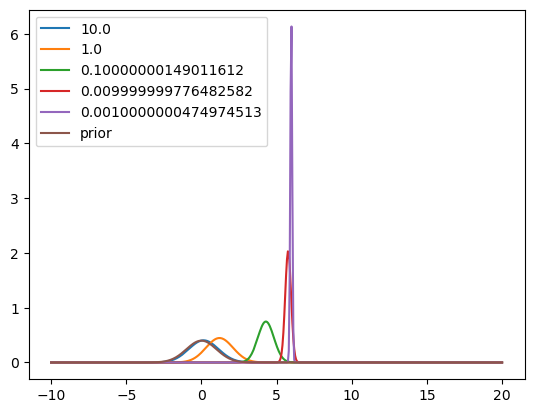

In [113]:
plt.plot(x_test.detach().numpy(),posterior_Numerical.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

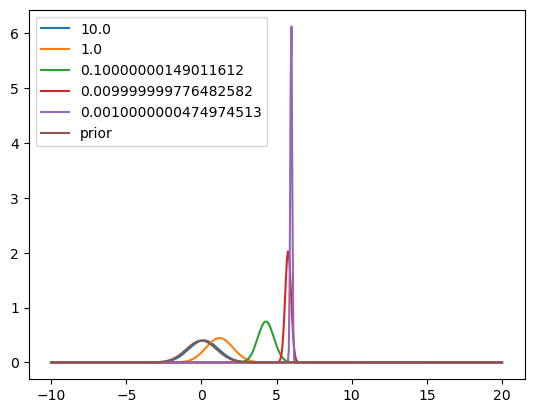

In [114]:
plt.plot(x_test.detach().numpy(),posterior_True.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

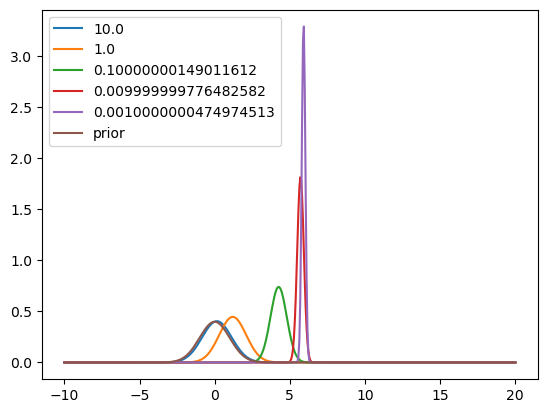

In [115]:
plt.plot(x_test.detach().numpy(),posterior_GPE.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

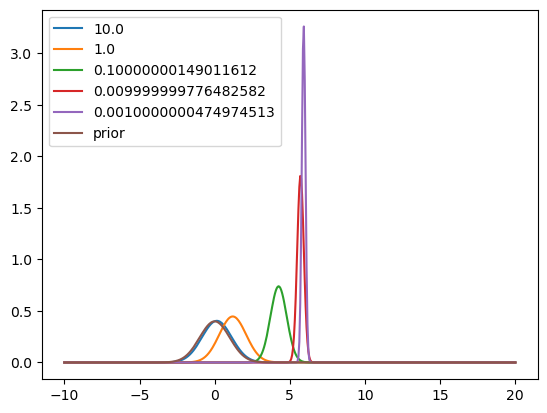

In [116]:
plt.plot(x_test.detach().numpy(),posterior_VI.detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(l)

In [117]:
obs_errors

tensor([1.0000e+01, 1.0000e+00, 1.0000e-01, 1.0000e-02, 1.0000e-03])

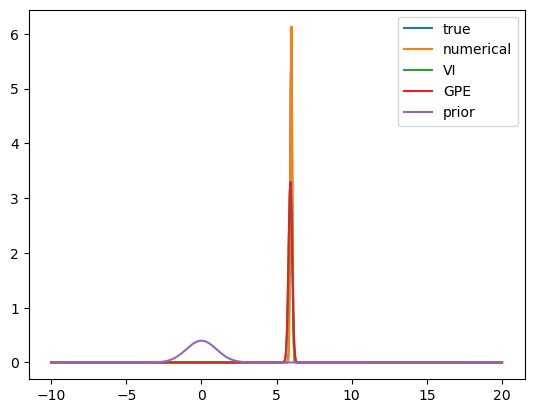

In [118]:
ref = 4
plt.plot(x_test.detach().numpy(),posterior_True[:,ref].detach().numpy())
plt.plot(x_test.detach().numpy(),posterior_Numerical[:,ref].detach().numpy())
plt.plot(x_test.detach().numpy(),posterior_VI[:,ref].detach().numpy())
plt.plot(x_test.detach().numpy(),posterior_GPE[:,ref].detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(['true','numerical','VI','GPE','prior'])

In [119]:
def acceptance(y,x,x_prime,sigma2): # Log acceptance for stability
    ratio = (-0.5*x_prime**2-0.5*(1/sigma2)*(b*x_prime-y)**2)-(-0.5*x**2-0.5*(1/sigma2)*(b*x-y)**2)
    alpha = np.min((0,ratio))
    return alpha

In [120]:
acceptance(0,1,2,1)

-1.875

In [121]:
np.random.uniform()

0.09258987937231777

In [122]:
def metrop(y,x0,sigma2_mc,sigma2,iters):
    chain = np.zeros(iters+1) #Initialise markov chain
    chain[0]=x0 #set x0 as first element
    for i in range(iters):
        x = chain[i] #define x
        x_p = np.random.normal(chain[i],sigma2_mc) #select candidate value x'
        alpha = acceptance(y,x,x_p,sigma2) #calculate alpha
        u=np.random.uniform() #generate random uniform variable
        if np.log(u)<alpha: 
            chain[i+1]=x_p #accept candidate value
        else:
            chain[i+1]=x #reject candidate value
    return chain

In [123]:
X = metrop(3,0,0.1,0.1,10000)

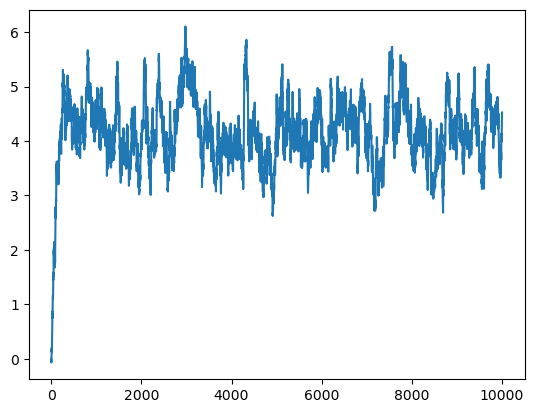

In [124]:
plt.plot(X)

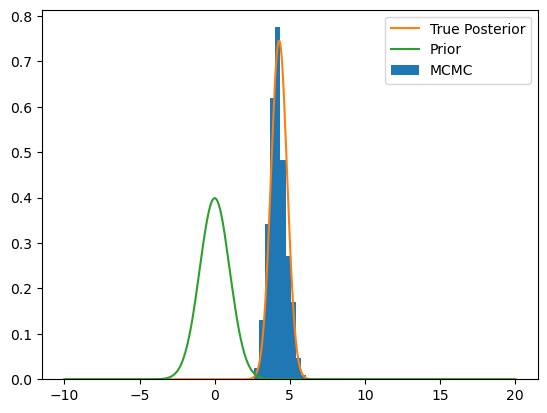

In [125]:
plt.hist(X[2000::],density=True)
plt.plot(x_test.detach().numpy(),posterior_True[:,2].detach().numpy())
plt.plot(x_test.detach().numpy(),val_prior.detach().numpy())
plt.legend(['True Posterior','Prior','MCMC'])

# $z=ax^2+by^2$

In [126]:
def ELBO(m,s2,x,emulator,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    #L=L.diagonal_scatter(s2)
    L[np.tril_indices(x.shape[0])]=s2
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
    
    z=z.T 
    
    mc_int = (emulator.ensemble_log_likelihood_obs_error(z,y,obs_error)+x_prior(z,prior_mean,prior_cov)[None]).mean()
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int - q_prior(covar)
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb
    

def ELBO_fun(m,s2,x,function,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    L[np.tril_indices(x.shape[0])]=s2
    
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
   
    z=z.T
    
    lb = (f_likelihood(z.T,y,function,obs_error)+x_prior(z[None],prior_mean,prior_cov)).mean()- q_prior(covar)
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb

def x_prior(x,mean,cov):

    #var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    #val1 = var.pdf(x)
    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    val = dist.log_prob(x)
    return val

def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+torch.log(torch.tensor(2*torch.pi)))-0.5*torch.log(torch.linalg.det(covar))
    return qp

def f_likelihood(x,y,f,sigma2):
    #x,f=emulator.normalise_test_data(x,f(x))
    #x,y=emulator.normalise_test_data(x,y)
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*torch.log(torch.tensor(2*np.pi))-0.5*torch.log(sigma2)
    return likelihood_manual

def f_likelihood2(x,y,f,sigma2):
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*np.log(2*np.pi)-0.5*np.log(sigma2)
    return likelihood_manual

In [127]:
p=100 #points for plotting

In [128]:
rl = -10 #lower bound
ru=10 #upper bound

In [129]:
obs_error = 0.001 #observational error

In [130]:
tp =20 #number of training points

In [131]:
x=torch.linspace(rl,ru,p) #x for plotting
y=torch.linspace(rl,ru,p) #y for plotting

In [132]:
a=0.1 #function parameters
b=0.3

In [133]:
def quad_2(x): #ax^2 + by^2 function
    #z = -a*x[0]**2 + -b*x[1]**2+10
    z=3*x[0]+5*x[1]
    return z

In [134]:
quad_2([0,0])

0

In [135]:
X,Y=torch.meshgrid(x,y)

/Users/pmzcwl/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [136]:
zp= quad_2([X,Y]) #z for plotting

In [137]:
zp.max()

tensor(80.)

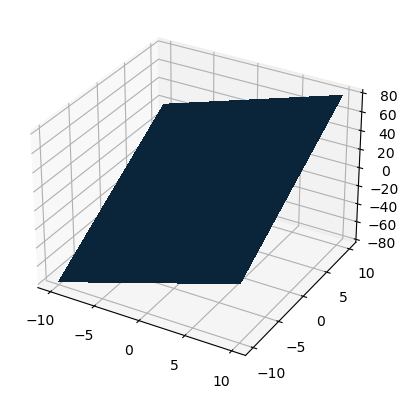

In [138]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y, zp,
                       linewidth=0, antialiased=False)

In [139]:
y = torch.FloatTensor(tp).uniform_(-10, 10) #y training points (randomly sampled)


In [140]:
x = torch.FloatTensor(tp).uniform_(-10, 10) #x training points (randomly sampled)

In [141]:
z = quad_2([x,y]) #+ np.random.normal(0,obs_error,x.shape) # function evaluated at training points

In [142]:
train_in = torch.stack((x,y)).T #convert to DF for emulator
train_out = z[:,None]

In [143]:
train_in.shape

torch.Size([20, 2])

In [144]:
emulator = GPE.ensemble(train_in,train_out,mean_func="constant",training_iter=500) #train emulator

0


In [145]:
test_points = 1000 # number of test points
dx = (ru-rl)/test_points #distance between each test point (y and x axes equal)
x_test = torch.stack((X.reshape(p**2),Y.reshape(p**2))).T #test dataset


In [146]:
x_test.shape

torch.Size([10000, 2])

In [147]:
emulator.predict(x_test).reshape(p,p)

tensor([[-78.9277, -77.9724, -77.0083,  ...,  17.9039,  18.9008,  19.8978],
        [-78.3540, -77.3907, -76.4301,  ...,  18.5042,  19.5064,  20.5025],
        [-77.7706, -76.8108, -75.8458,  ...,  19.1045,  20.1138,  21.1089],
        ...,
        [-21.0469, -20.0500, -19.0601,  ...,  76.6648,  77.6467,  78.6285],
        [-20.4422, -19.4479, -18.4563,  ...,  77.2615,  78.2390,  79.2209],
        [-19.8357, -18.8459, -17.8507,  ...,  77.8512,  78.8375,  79.8220]],
       grad_fn=<ViewBackward0>)

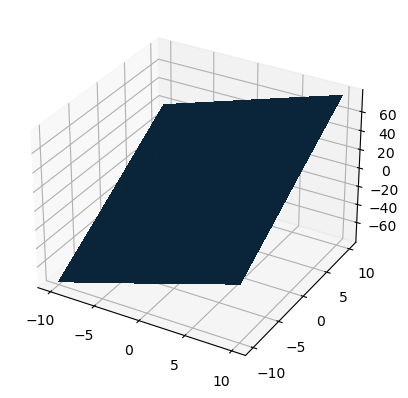

In [148]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) #visualise emulator over test

# Plot the surface.
surf = ax.plot_surface(X, Y, emulator.predict(x_test).detach().numpy().reshape(p,p),
                       linewidth=0, antialiased=False)

In [149]:
prior_mean=torch.tensor([0,0])
prior_cov = torch.tensor([10,10])*torch.eye(2)
obs_error = torch.tensor(1)
y_cal = torch.tensor([10])

In [150]:
prior_cov.shape

torch.Size([2, 2])

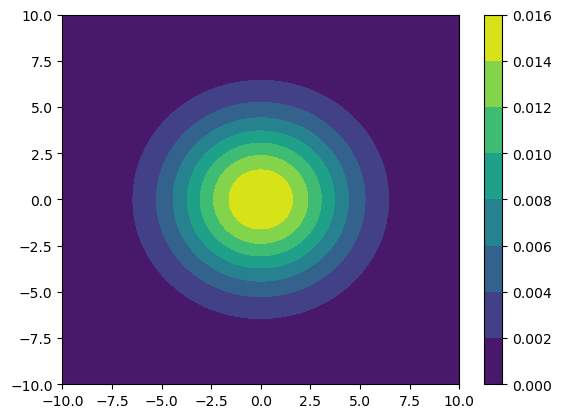

In [151]:
dist_prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)
val_prior = torch.exp(dist_prior.log_prob(x_test))

plt.contourf(X,Y,val_prior.reshape(p,p))
plt.colorbar()

In [152]:
Z = torch.randn((nsamples,2), dtype=dtype, requires_grad=False, device=device)

In [153]:
Z.shape

torch.Size([1000, 2])

In [154]:
### initialize the variational parameters
m = torch.full((2,1), 10.,dtype=dtype, requires_grad=True, device=device)
s2 = torch.full((3,),1.,dtype=dtype , requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(5000):
    Z = torch.randn((2,nsamples), dtype=dtype, requires_grad=False, device=device)
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    
    negELBO = ELBO_fun(m,s2,Z,quad_2,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    #if t % 100 == 99:
        #print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
      #  print(m)
      #  print(s2)
      #   print(negELBO)
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():

        m -= learning_rate * m.grad
        s2 -= learning_rate * s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        s2.grad = None
        
#print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

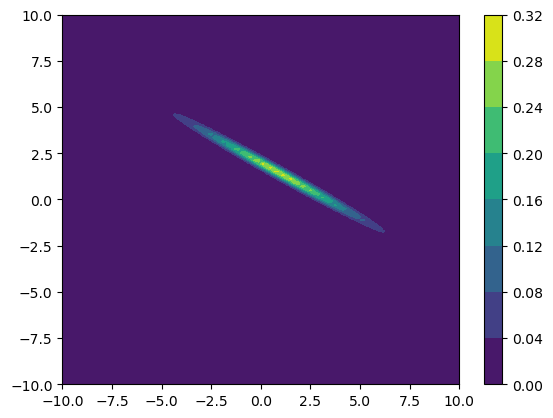

In [155]:
#establish VI posterior
L=torch.zeros((Z.shape[0],Z.shape[0]))
L[np.tril_indices(Z.shape[0])]=s2
covar = L.matmul(L.T)

dist = MultivariateNormal(loc=m.squeeze(), covariance_matrix=covar)
val= torch.exp(dist.log_prob(x_test))


#var_prior = scipy.stats.multivariate_normal(mean=m.squeeze().detach().numpy(), cov=(torch.eye(2)*(s2**2)).detach().numpy())
#val = var_prior.pdf(x_test.detach().numpy())

plt.contourf(X.detach().numpy(),Y.detach().numpy(),val.reshape(p,p).detach().numpy())
plt.colorbar()

In [156]:
### initialize the variational parameters
m = torch.full((2,1), 10.,dtype=dtype, requires_grad=True, device=device)
s2 = torch.full((3,),1.,dtype=dtype , requires_grad=True, device=device)


# Samples fixed here - but try adding them into the loop
nsamples = 1000
#Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

learning_rate = 1e-2
for t in range(5000):
    Z = torch.randn((2,nsamples), dtype=dtype, requires_grad=False, device=device)
    #negELBO = -Eloglike(m,log_s2)+KL(log_s2)
    obs_error=torch.tensor([obs_error])
    negELBO = ELBO(m,s2,Z,emulator,y_cal[:,None],prior_mean,prior_cov,obs_error)
    
    #if t % 100 == 99:
        #print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
      #  print(m)
      #  print(s2)
      #   print(negELBO)
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
    # the gradient of the loss with respect to a, b, c, d respectively.
    negELBO.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.
    with torch.no_grad():

        m -= learning_rate * m.grad
        s2 -= learning_rate * s2.grad
        
        # Manually zero the gradients after updating weights
        m.grad = None
        s2.grad = None
        
#print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

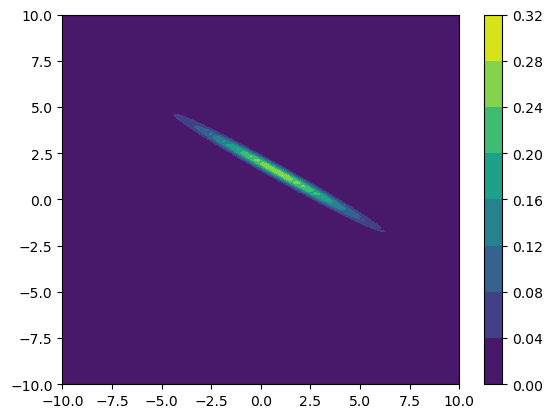

In [157]:
#establish VI posterior
L=torch.zeros((Z.shape[0],Z.shape[0]))
L[np.tril_indices(Z.shape[0])]=s2
covar = L.matmul(L.T)

dist = MultivariateNormal(loc=m.squeeze(), covariance_matrix=covar)
val2= torch.exp(dist.log_prob(x_test))


#var_prior = scipy.stats.multivariate_normal(mean=m.squeeze().detach().numpy(), cov=(torch.eye(2)*(s2**2)).detach().numpy())
#val = var_prior.pdf(x_test.detach().numpy())

plt.contourf(X.detach().numpy(),Y.detach().numpy(),val2.reshape(p,p).detach().numpy())
plt.colorbar()

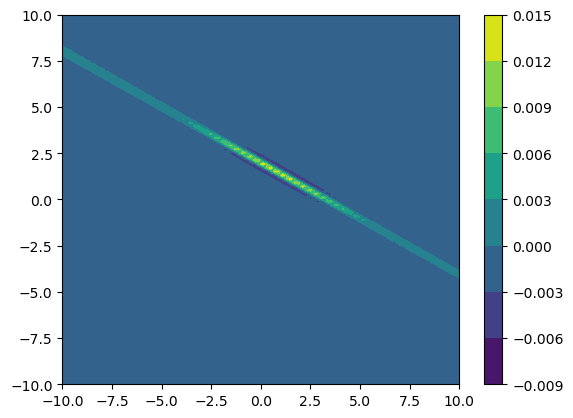

In [158]:
plt.contourf(X.detach().numpy(),Y.detach().numpy(),(val-val2).reshape(p,p).detach().numpy())
plt.colorbar()

In [159]:
m

tensor([[0.9061],
        [1.4508]], requires_grad=True)

In [160]:
s2**2

tensor([7.3622, 2.6295, 0.0433], grad_fn=<PowBackward0>)

In [161]:
obs_error

tensor([1])

In [162]:
likelihood = torch.exp(emulator.ensemble_log_likelihood_obs_error(x_test,y_cal[:,None],obs_error)) #Generate likelihood from GP

In [163]:
posterior = likelihood*val_prior / (torch.sum(likelihood*val_prior)*dx*dx) #Generate posterior from GP

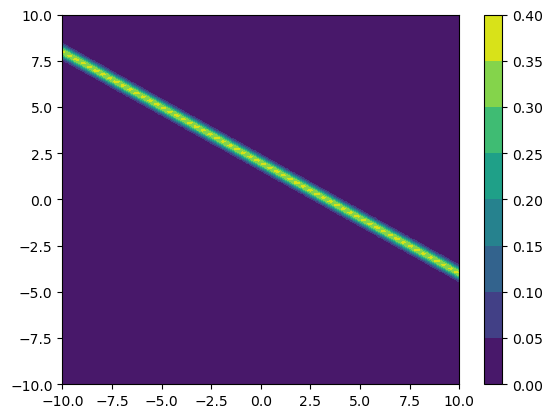

In [164]:
plt.contourf(X.detach().numpy(),Y.detach().numpy(),likelihood.reshape(p,p).detach().numpy()) #Visualise likelihood
plt.colorbar()

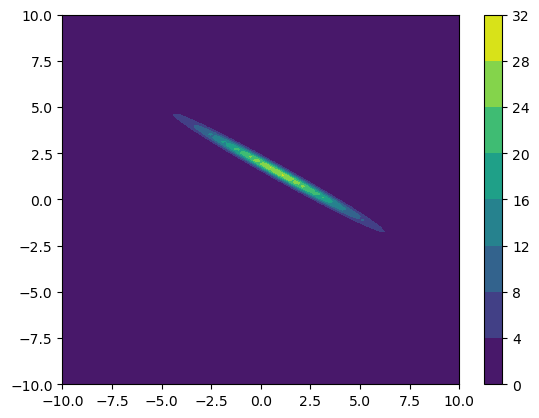

In [165]:
plt.contourf(X,Y,posterior.reshape(p,p).detach().numpy()) #visualise posterior
plt.colorbar()

In [166]:
true_likelihood= f_likelihood([X,Y],y_cal[:,None],quad_2,obs_error) #Generate numerical log likelihood

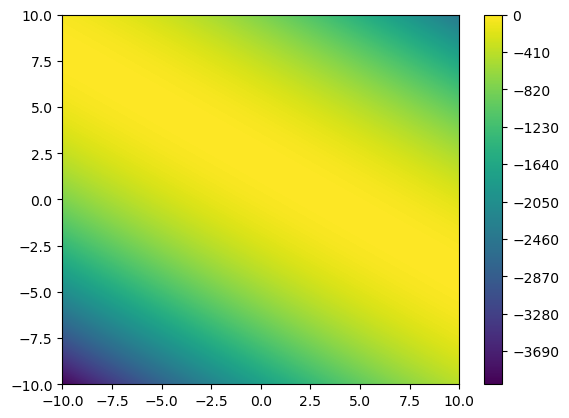

In [167]:
plt.contourf(X,Y,true_likelihood.reshape(p,p).detach().numpy(),levels=1000) #visualise numerical likelihood

plt.colorbar()

In [168]:
true_likelihood=torch.exp(true_likelihood) #Generate numerical likelihood

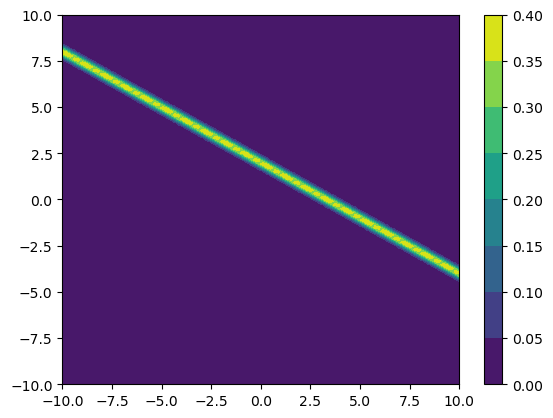

In [169]:
plt.contourf(X,Y,true_likelihood.reshape(p,p).detach().numpy()) #visualise numerical likelihood
plt.colorbar()

In [170]:
#calculate numerical posterior
true_posterior = true_likelihood.squeeze()*val_prior.reshape(p,p) / (torch.sum(true_likelihood.squeeze()*val_prior.reshape(p,p))*0.2)

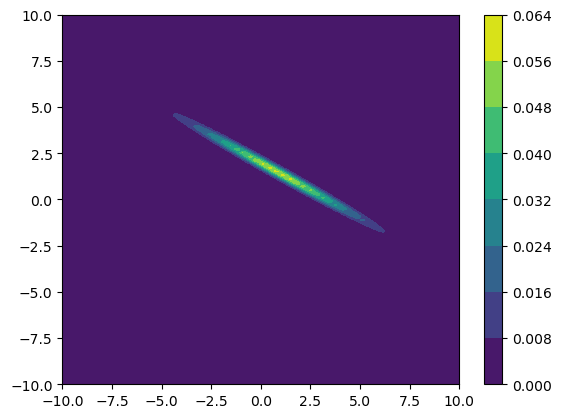

In [171]:
plt.contourf(X,Y,true_posterior.reshape(p,p).detach().numpy()) #visualise numerical posterior
plt.colorbar()

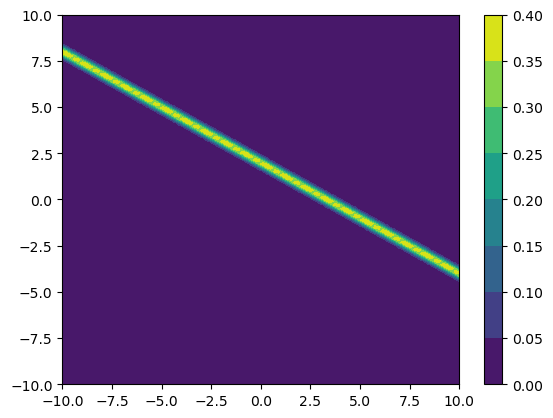

In [172]:
plt.contourf(X,Y,true_likelihood.reshape(p,p).detach().numpy()) #visualise numerical likelihood
plt.colorbar()

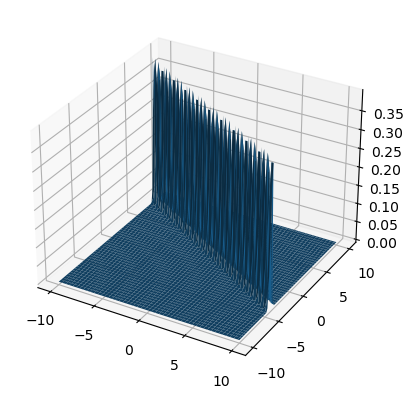

In [173]:
#numerical likelihood in 3D
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(X, Y,true_likelihood.reshape(p,p))

# EP Data

In [354]:
x_labels=pd.read_csv('/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/xlabels_EP.txt',delim_whitespace=True,header=None)
inputOrig = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/input/X_EP.txt',index_col=None,delim_whitespace=True,header=None)
inputOrig.columns=x_labels
print(inputOrig)

     (CV_ventricles,)  (k_ventricles,)  (k_FEC,)  (CV_atria,)  (k_atria,)  \
0            0.399840         0.323390   2.38256     0.792266    0.418700   
1            0.411078         0.484808   2.97470     0.436497    0.392057   
2            0.480070         0.255120   5.45824     0.707493    0.233964   
3            0.723138         0.219679   7.08363     1.011880    0.440564   
4            0.613551         0.212641   6.01868     0.914252    0.278204   
..                ...              ...       ...          ...         ...   
175          0.787312         0.392919   4.22219     0.385685    0.226360   
176          0.436460         0.348932   3.06019     0.699568    0.471580   
177          0.484816         0.466268   1.34156     0.437907    0.377097   
178          0.734602         0.210847   1.62463     0.444901    0.404824   
179          0.692167         0.415612   3.02559     0.847270    0.442109   

     (k_BB,)  
0    5.13714  
1    2.72577  
2    5.18898  
3    2.02218  


In [355]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/ylabels.txt',delim_whitespace=True,header=None)
outputOrig = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/EP_healthy/output/Y.txt',index_col=None,delim_whitespace=True,header=None)
outputOrig.columns=y_labels
print(outputOrig)

     (A_TAT,)  (V_TAT,)
0     127.156  227.8230
1     251.071  188.8540
2     163.448  164.8120
3     110.207  110.6940
4     140.815  136.1450
..        ...       ...
175   321.082   94.4139
176   141.936  190.0140
177   236.662  224.8330
178   248.667  167.9450
179   118.693  115.3070

[180 rows x 2 columns]


In [356]:
inputOrig.iloc[:,[0,2,3]]

(CV_ventricles,)  (k_FEC,)  (CV_atria,)
0            0.399840   2.38256     0.792266
1            0.411078   2.97470     0.436497
2            0.480070   5.45824     0.707493
3            0.723138   7.08363     1.011880
4            0.613551   6.01868     0.914252
..                ...       ...          ...
175          0.787312   4.22219     0.385685
176          0.436460   3.06019     0.699568
177          0.484816   1.34156     0.437907
178          0.734602   1.62463     0.444901
179          0.692167   3.02559     0.847270

[180 rows x 3 columns]

In [357]:
# split original dataset in training, validation and testing sets
X=torch.tensor(inputOrig.values)#.iloc[:,[0,2,3]].values)
y=torch.tensor(outputOrig.values)
x_train, x_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=1,
    random_state=seed
)

In [358]:
nDim = x_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([torch.min(x_train[:,i]),torch.max(x_train[:,i])])
    print(boundsMaxMin[i])

[tensor(0.3802, dtype=torch.float64), tensor(0.7989, dtype=torch.float64)]
[tensor(0.2001, dtype=torch.float64), tensor(0.4992, dtype=torch.float64)]
[tensor(1.2120, dtype=torch.float64), tensor(8.3968, dtype=torch.float64)]
[tensor(0.3003, dtype=torch.float64), tensor(1.0293, dtype=torch.float64)]
[tensor(0.2012, dtype=torch.float64), tensor(0.4999, dtype=torch.float64)]
[tensor(1.0221, dtype=torch.float64), tensor(5.6757, dtype=torch.float64)]


In [359]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [360]:
emulator = GPE.ensemble(x_train,y_train,mean_func="linear",training_iter=500)

0
1


In [361]:
x_train.shape[1]

6

tensor([[0.0049, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0025, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.4339, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0148, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0025, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6016]], dtype=torch.float64)

In [474]:
prior_covar = 0.1*torch.eye(x_train.shape[1]) #prior covariance and mean
prior_covar =torch.eye(x_train.shape[1])*((np.array(boundsMaxMin)[:,1]-np.array(boundsMaxMin)[:,0])/3)**2
prior_mean=torch.tensor(centre)
obs_error = torch.tensor([0.001,0.001])

In [475]:
prior_covar

tensor([[0.0195, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0099, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 5.7358, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0590, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0099, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4063]], dtype=torch.float64)

In [476]:
prior_mean

tensor([0.5895, 0.3497, 4.8044, 0.6648, 0.3505, 3.3489], dtype=torch.float64)

In [477]:
x_prior(torch.ones(6),prior_mean,prior_covar)

tensor(-49.0642, dtype=torch.float64)

In [478]:
L=torch.zeros((x_train.shape[1],x_train.shape[1]))
L[np.tril_indices(x_train.shape[1])]=s2

In [479]:
len(np.tril_indices(x_train.shape[1])[0])

21

In [480]:
L[np.tril_indices(x_train.shape[1])]

tensor([-2.8867, -5.6870, -2.9939, -4.2488, -3.7909, -1.0813, -5.7293, -5.4765,
        -5.7674, -3.3545, -5.5246, -5.3979, -5.5415, -6.2221, -2.9454, -3.6047,
        -3.5868, -3.4185, -3.5208, -4.3630, -1.2162], grad_fn=<IndexBackward0>)

In [481]:
obs_error=[0.01,0.01]

In [482]:
s2

tensor([-2.8867, -5.6870, -2.9939, -4.2488, -3.7909, -1.0813, -5.7293, -5.4765,
        -5.7674, -3.3545, -5.5246, -5.3979, -5.5415, -6.2221, -2.9454, -3.6047,
        -3.5868, -3.4185, -3.5208, -4.3630, -1.2162], requires_grad=True)

In [483]:
torch.full((6,1), 1.,dtype=dtype, requires_grad=True, device=device)*torch.tensor(centre)[:,None]

tensor([[0.5895],
        [0.3497],
        [4.8044],
        [0.6648],
        [0.3505],
        [3.3489]], dtype=torch.float64, grad_fn=<MulBackward0>)

In [484]:
torch.tensor(centre,requires_grad=True)

tensor([0.5895, 0.3497, 4.8044, 0.6648, 0.3505, 3.3489], dtype=torch.float64,
       requires_grad=True)

In [485]:
def ELBO(m,s2,x,emulator,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    #L=L.diagonal_scatter(s2)
    L[np.tril_indices(x.shape[0])]=torch.exp(s2)
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
    
    z=z.T 
    
    mc_int = (emulator.ensemble_log_likelihood_obs_error(z,y,obs_error)+x_prior(z,prior_mean,prior_cov)[None]).mean()
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    lb = mc_int - q_prior(covar)
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb
    

def ELBO_fun(m,s2,x,function,y,prior_mean,prior_cov,obs_error):
    
    L=torch.zeros((x.shape[0],x.shape[0]))
    L[np.tril_indices(x.shape[0])]=torch.exp(s2)
    
    #L[1,0]=param[6]
   # L[2,0]=param[7]
   # L[2,1] =param[8]
    covar = L.matmul(L.T)
    z=L.matmul(x)+m
   
    z=z.T
    
    lb = (f_likelihood(z.T,y,function,obs_error)+x_prior(z[None],prior_mean,prior_cov)).mean()- q_prior(covar)
        #mc_int +=-np.log(np.sum(((emulator.predict(z.iloc[[i]]).detach().numpy()-y.values)**2)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov))
        #mc_int += (np.sum(np.log(emulator.ensemble_likelihood(z.iloc[[i]],y)))+np.log(x_prior(z.iloc[[i]],prior_mean,prior_cov)))
    
    #print(mc_int/x.shape[1])
    #print(-q_prior(covar))
    #print(np.mean(z,axis=0))
    #print(-lb)
    return -lb

def x_prior(x,mean,cov):

    #var = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    #val1 = var.pdf(x)
    dist = MultivariateNormal(loc=mean, covariance_matrix=cov)
    val = dist.log_prob(x)
    return val

def q_prior(covar):
    qp = -(covar.shape[0]/2)*(1+torch.log(torch.tensor(2*torch.pi)))-0.5*torch.log(torch.linalg.det(covar))
    return qp

def f_likelihood(x,y,f,sigma2):
    #x,f=emulator.normalise_test_data(x,f(x))
    #x,y=emulator.normalise_test_data(x,y)
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*torch.log(torch.tensor(2*np.pi))-0.5*torch.log(sigma2)
    return likelihood_manual

def f_likelihood2(x,y,f,sigma2):
    
    likelihood_manual=-0.5*((f(x) - y)**2)/(sigma2)- 0.5*np.log(2*np.pi)-0.5*np.log(sigma2)
    return likelihood_manual

In [493]:
torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6)).sample()  

tensor([ 0.0852,  0.4587,  0.7763,  0.4600,  0.2461, -1.4523])

In [503]:
elb = []
ms=[]
s2s=[]

for i in range(10):

    ### initialize the variational parameters
    noi=torch.distributions.MultivariateNormal(torch.zeros(6), torch.eye(6)).sample()  
    m = torch.tensor(centre,requires_grad=True)[:,None]+noi[:,None]
    m.retain_grad()
    s2 = torch.full((len(np.tril_indices(x_train.shape[1])[0]),),0.01,dtype=dtype , requires_grad=True, device=device)


    # Samples fixed here - but try adding them into the loop
    nsamples = 10000
    #Z = torch.randn((nsamples), dtype=dtype, requires_grad=False, device=device)

    learning_rate = 1e-3
    for t in range(20000):
        Z = torch.randn((6,nsamples), dtype=dtype, requires_grad=False, device=device)
        #negELBO = -Eloglike(m,log_s2)+KL(log_s2)

        negELBO = ELBO(m,s2,Z,emulator,y_test,prior_mean,prior_covar,obs_error)

        if t % 100 == 99:
            print(t,negELBO.item(),'m=',m)
            #print(t, negELBO.item(), 'm=', m.item(), 's2=', s2.pow(2).item())
          #  print(m)
          #  print(s2)
          #   print(negELBO)
        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call a.grad, b.grad. c.grad and d.grad will be Tensors holding
        # the gradient of the loss with respect to a, b, c, d respectively.
        negELBO.backward()

        # Manually update weights using gradient descent. Wrap in torch.no_grad()
        # because weights have requires_grad=True, but we don't need to track this
        # in autograd.
        with torch.no_grad():

            m -= learning_rate * m.grad
            s2 -= learning_rate * s2.grad

            # Manually zero the gradients after updating weights
            m.grad = None
            s2.grad = None
    elb.append(negELBO)
    ms.append(m)
    s2s.append(s2)
    #print(f'Result: p(x|y) = N({m.item()}, {torch.pow(s2,2).item()}) ')

99 79.57202294612811 m= tensor([[1.0803],
        [0.2927],
        [2.9597],
        [0.5424],
        [0.9922],
        [2.2184]], dtype=torch.float64, grad_fn=<AddBackward0>)
199 42.011684085226634 m= tensor([[1.0489],
        [0.2749],
        [2.9881],
        [1.2640],
        [0.5053],
        [1.8436]], dtype=torch.float64, grad_fn=<AddBackward0>)
299 30.57661526977456 m= tensor([[0.9997],
        [0.3287],
        [3.0342],
        [1.2585],
        [0.1988],
        [1.7662]], dtype=torch.float64, grad_fn=<AddBackward0>)
399 27.051557255631593 m= tensor([[0.9872],
        [0.3355],
        [3.0883],
        [1.2528],
        [0.2155],
        [1.7288]], dtype=torch.float64, grad_fn=<AddBackward0>)
499 25.114366805751448 m= tensor([[0.9789],
        [0.3369],
        [3.1462],
        [1.2485],
        [0.2238],
        [1.6938]], dtype=torch.float64, grad_fn=<AddBackward0>)
599 23.98711592185933 m= tensor([[0.9725],
        [0.3374],
        [3.2073],
        [1.2455],
      

4699 17.53888782430529 m= tensor([[0.8924],
        [0.3486],
        [4.6121],
        [1.2325],
        [0.2703],
        [0.7906]], dtype=torch.float64, grad_fn=<AddBackward0>)
4799 17.430516059925665 m= tensor([[0.8918],
        [0.3494],
        [4.6324],
        [1.2324],
        [0.2712],
        [0.7739]], dtype=torch.float64, grad_fn=<AddBackward0>)
4899 17.471839091672052 m= tensor([[0.8900],
        [0.3501],
        [4.6525],
        [1.2323],
        [0.2712],
        [0.7571]], dtype=torch.float64, grad_fn=<AddBackward0>)
4999 17.376167465149138 m= tensor([[0.8907],
        [0.3495],
        [4.6732],
        [1.2310],
        [0.2726],
        [0.7404]], dtype=torch.float64, grad_fn=<AddBackward0>)
5099 17.375472803727707 m= tensor([[0.8884],
        [0.3499],
        [4.6941],
        [1.2305],
        [0.2737],
        [0.7242]], dtype=torch.float64, grad_fn=<AddBackward0>)
5199 17.315020416211354 m= tensor([[0.8887],
        [0.3500],
        [4.7149],
        [1.2309

9299 16.57174485800973 m= tensor([[0.8562],
        [0.3756],
        [5.7647],
        [1.2060],
        [0.3173],
        [0.1659]], dtype=torch.float64, grad_fn=<AddBackward0>)
9399 16.59522194818205 m= tensor([[0.8551],
        [0.3755],
        [5.7800],
        [1.2056],
        [0.3175],
        [0.1598]], dtype=torch.float64, grad_fn=<AddBackward0>)
9499 16.594135566268697 m= tensor([[0.8543],
        [0.3761],
        [5.7942],
        [1.2050],
        [0.3181],
        [0.1543]], dtype=torch.float64, grad_fn=<AddBackward0>)
9599 16.529275549666423 m= tensor([[0.8541],
        [0.3759],
        [5.8074],
        [1.2038],
        [0.3187],
        [0.1483]], dtype=torch.float64, grad_fn=<AddBackward0>)
9699 16.548087757557152 m= tensor([[0.8543],
        [0.3755],
        [5.8192],
        [1.2028],
        [0.3189],
        [0.1428]], dtype=torch.float64, grad_fn=<AddBackward0>)
9799 16.443320019394548 m= tensor([[0.8533],
        [0.3748],
        [5.8305],
        [1.2039]

13899 16.437203408337385 m= tensor([[0.8546],
        [0.3766],
        [5.9586],
        [1.1897],
        [0.3304],
        [0.0734]], dtype=torch.float64, grad_fn=<AddBackward0>)
13999 16.385356204172595 m= tensor([[0.8546],
        [0.3766],
        [5.9584],
        [1.1890],
        [0.3306],
        [0.0731]], dtype=torch.float64, grad_fn=<AddBackward0>)
14099 16.370917383815538 m= tensor([[0.8555],
        [0.3764],
        [5.9579],
        [1.1890],
        [0.3318],
        [0.0726]], dtype=torch.float64, grad_fn=<AddBackward0>)
14199 16.543524415016115 m= tensor([[0.8581],
        [0.3781],
        [5.9570],
        [1.1890],
        [0.3311],
        [0.0721]], dtype=torch.float64, grad_fn=<AddBackward0>)
14299 16.552634828567122 m= tensor([[0.8593],
        [0.3789],
        [5.9566],
        [1.1885],
        [0.3316],
        [0.0719]], dtype=torch.float64, grad_fn=<AddBackward0>)
14399 16.368423342372513 m= tensor([[0.8566],
        [0.3767],
        [5.9555],
        

18499 16.384153941812706 m= tensor([[0.8618],
        [0.3782],
        [5.9120],
        [1.1781],
        [0.3360],
        [0.0810]], dtype=torch.float64, grad_fn=<AddBackward0>)
18599 16.18970457534665 m= tensor([[0.8583],
        [0.3755],
        [5.9107],
        [1.1777],
        [0.3363],
        [0.0811]], dtype=torch.float64, grad_fn=<AddBackward0>)
18699 16.145565892371046 m= tensor([[0.8577],
        [0.3756],
        [5.9098],
        [1.1771],
        [0.3363],
        [0.0815]], dtype=torch.float64, grad_fn=<AddBackward0>)
18799 16.230375910036297 m= tensor([[0.8587],
        [0.3752],
        [5.9087],
        [1.1780],
        [0.3363],
        [0.0823]], dtype=torch.float64, grad_fn=<AddBackward0>)
18899 16.158928872404147 m= tensor([[0.8577],
        [0.3741],
        [5.9072],
        [1.1777],
        [0.3370],
        [0.0824]], dtype=torch.float64, grad_fn=<AddBackward0>)
18999 16.143149504193133 m= tensor([[0.8570],
        [0.3741],
        [5.9063],
        [

3099 18.258950595366084 m= tensor([[0.9046],
        [0.3475],
        [4.2959],
        [1.2334],
        [0.2237],
        [1.6627]], dtype=torch.float64, grad_fn=<AddBackward0>)
3199 18.300829824313407 m= tensor([[0.9041],
        [0.3484],
        [4.3157],
        [1.2339],
        [0.2249],
        [1.6244]], dtype=torch.float64, grad_fn=<AddBackward0>)
3299 18.269672104620653 m= tensor([[0.9034],
        [0.3477],
        [4.3351],
        [1.2341],
        [0.2260],
        [1.5872]], dtype=torch.float64, grad_fn=<AddBackward0>)
3399 18.107758390227588 m= tensor([[0.9029],
        [0.3477],
        [4.3546],
        [1.2343],
        [0.2282],
        [1.5509]], dtype=torch.float64, grad_fn=<AddBackward0>)
3499 18.032881180666323 m= tensor([[0.9024],
        [0.3492],
        [4.3735],
        [1.2340],
        [0.2301],
        [1.5159]], dtype=torch.float64, grad_fn=<AddBackward0>)
3599 18.060953468574162 m= tensor([[0.9014],
        [0.3477],
        [4.3922],
        [1.233

7699 16.88594676989001 m= tensor([[0.8605],
        [0.3598],
        [5.2798],
        [1.2253],
        [0.2821],
        [0.5202]], dtype=torch.float64, grad_fn=<AddBackward0>)
7799 16.790831055358222 m= tensor([[0.8567],
        [0.3600],
        [5.3102],
        [1.2242],
        [0.2839],
        [0.5008]], dtype=torch.float64, grad_fn=<AddBackward0>)
7899 16.725971251355944 m= tensor([[0.8576],
        [0.3608],
        [5.3408],
        [1.2243],
        [0.2857],
        [0.4819]], dtype=torch.float64, grad_fn=<AddBackward0>)
7999 16.71474026116374 m= tensor([[0.8544],
        [0.3609],
        [5.3717],
        [1.2238],
        [0.2864],
        [0.4628]], dtype=torch.float64, grad_fn=<AddBackward0>)
8099 16.646812213386426 m= tensor([[0.8538],
        [0.3617],
        [5.4026],
        [1.2224],
        [0.2891],
        [0.4441]], dtype=torch.float64, grad_fn=<AddBackward0>)
8199 16.61928238826807 m= tensor([[0.8517],
        [0.3631],
        [5.4336],
        [1.2210],

12299 16.654299362385807 m= tensor([[0.8579],
        [0.3791],
        [5.9513],
        [1.1938],
        [0.3284],
        [0.0784]], dtype=torch.float64, grad_fn=<AddBackward0>)
12399 16.41979503922742 m= tensor([[0.8553],
        [0.3769],
        [5.9528],
        [1.1929],
        [0.3276],
        [0.0774]], dtype=torch.float64, grad_fn=<AddBackward0>)
12499 16.49114067306814 m= tensor([[0.8548],
        [0.3773],
        [5.9543],
        [1.1930],
        [0.3278],
        [0.0763]], dtype=torch.float64, grad_fn=<AddBackward0>)
12599 16.330143804956684 m= tensor([[0.8522],
        [0.3758],
        [5.9553],
        [1.1930],
        [0.3281],
        [0.0753]], dtype=torch.float64, grad_fn=<AddBackward0>)
12699 16.5045418102503 m= tensor([[0.8568],
        [0.3786],
        [5.9567],
        [1.1921],
        [0.3292],
        [0.0746]], dtype=torch.float64, grad_fn=<AddBackward0>)
12799 16.560765112459556 m= tensor([[0.8563],
        [0.3774],
        [5.9575],
        [1.1

16899 16.289249154980812 m= tensor([[0.8565],
        [0.3768],
        [5.9338],
        [1.1808],
        [0.3356],
        [0.0752]], dtype=torch.float64, grad_fn=<AddBackward0>)
16999 16.38139566907249 m= tensor([[0.8601],
        [0.3773],
        [5.9326],
        [1.1802],
        [0.3342],
        [0.0750]], dtype=torch.float64, grad_fn=<AddBackward0>)
17099 16.267913409903183 m= tensor([[0.8571],
        [0.3767],
        [5.9314],
        [1.1804],
        [0.3356],
        [0.0752]], dtype=torch.float64, grad_fn=<AddBackward0>)
17199 16.270756075889302 m= tensor([[0.8572],
        [0.3761],
        [5.9303],
        [1.1798],
        [0.3350],
        [0.0753]], dtype=torch.float64, grad_fn=<AddBackward0>)
17299 16.279425711590953 m= tensor([[0.8574],
        [0.3753],
        [5.9287],
        [1.1813],
        [0.3355],
        [0.0762]], dtype=torch.float64, grad_fn=<AddBackward0>)
17399 16.234622733816888 m= tensor([[0.8553],
        [0.3752],
        [5.9272],
        [

1499 20.336178485090535 m= tensor([[0.9207],
        [0.3409],
        [4.2057],
        [1.2185],
        [0.1796],
        [2.7417]], dtype=torch.float64, grad_fn=<AddBackward0>)
1599 20.051799318146927 m= tensor([[0.9171],
        [0.3418],
        [4.2255],
        [1.2208],
        [0.1832],
        [2.6695]], dtype=torch.float64, grad_fn=<AddBackward0>)
1699 19.831013481796465 m= tensor([[0.9160],
        [0.3419],
        [4.2445],
        [1.2216],
        [0.1851],
        [2.5993]], dtype=torch.float64, grad_fn=<AddBackward0>)
1799 19.753299564703553 m= tensor([[0.9155],
        [0.3432],
        [4.2624],
        [1.2231],
        [0.1879],
        [2.5310]], dtype=torch.float64, grad_fn=<AddBackward0>)
1899 19.575302795990098 m= tensor([[0.9138],
        [0.3430],
        [4.2799],
        [1.2244],
        [0.1903],
        [2.4648]], dtype=torch.float64, grad_fn=<AddBackward0>)
1999 19.48794350503257 m= tensor([[0.9127],
        [0.3436],
        [4.2969],
        [1.2265

6099 17.21302287121443 m= tensor([[0.8760],
        [0.3524],
        [4.9829],
        [1.2326],
        [0.2583],
        [0.8940]], dtype=torch.float64, grad_fn=<AddBackward0>)
6199 17.096316465721657 m= tensor([[0.8749],
        [0.3528],
        [5.0056],
        [1.2331],
        [0.2600],
        [0.8721]], dtype=torch.float64, grad_fn=<AddBackward0>)
6299 17.213628037125428 m= tensor([[0.8744],
        [0.3540],
        [5.0290],
        [1.2327],
        [0.2617],
        [0.8500]], dtype=torch.float64, grad_fn=<AddBackward0>)
6399 17.106754906718216 m= tensor([[0.8713],
        [0.3527],
        [5.0531],
        [1.2338],
        [0.2628],
        [0.8285]], dtype=torch.float64, grad_fn=<AddBackward0>)
6499 17.12066457221572 m= tensor([[0.8725],
        [0.3549],
        [5.0779],
        [1.2328],
        [0.2639],
        [0.8071]], dtype=torch.float64, grad_fn=<AddBackward0>)
6599 17.087561158610523 m= tensor([[0.8696],
        [0.3548],
        [5.1031],
        [1.2320]

10699 16.446381351810665 m= tensor([[0.8224],
        [0.3610],
        [5.9304],
        [1.2017],
        [0.3196],
        [0.1266]], dtype=torch.float64, grad_fn=<AddBackward0>)
10799 16.36250099224556 m= tensor([[0.8230],
        [0.3603],
        [5.9352],
        [1.1995],
        [0.3205],
        [0.1203]], dtype=torch.float64, grad_fn=<AddBackward0>)
10899 16.38589582989271 m= tensor([[0.8226],
        [0.3610],
        [5.9396],
        [1.1998],
        [0.3220],
        [0.1150]], dtype=torch.float64, grad_fn=<AddBackward0>)
10999 16.277233364513705 m= tensor([[0.8224],
        [0.3609],
        [5.9438],
        [1.1988],
        [0.3219],
        [0.1103]], dtype=torch.float64, grad_fn=<AddBackward0>)
11099 16.31170439218229 m= tensor([[0.8228],
        [0.3597],
        [5.9471],
        [1.1985],
        [0.3230],
        [0.1055]], dtype=torch.float64, grad_fn=<AddBackward0>)
11199 16.335135004793045 m= tensor([[0.8229],
        [0.3593],
        [5.9507],
        [1.

15299 16.080908928346748 m= tensor([[0.8246],
        [0.3576],
        [5.9563],
        [1.1854],
        [0.3320],
        [0.0692]], dtype=torch.float64, grad_fn=<AddBackward0>)
15399 16.099277891032674 m= tensor([[0.8233],
        [0.3587],
        [5.9554],
        [1.1843],
        [0.3338],
        [0.0696]], dtype=torch.float64, grad_fn=<AddBackward0>)
15499 16.047152985570712 m= tensor([[0.8250],
        [0.3589],
        [5.9542],
        [1.1839],
        [0.3334],
        [0.0693]], dtype=torch.float64, grad_fn=<AddBackward0>)
15599 16.1264280624657 m= tensor([[0.8236],
        [0.3578],
        [5.9526],
        [1.1835],
        [0.3342],
        [0.0697]], dtype=torch.float64, grad_fn=<AddBackward0>)
15699 16.152561437084387 m= tensor([[0.8233],
        [0.3579],
        [5.9512],
        [1.1829],
        [0.3342],
        [0.0701]], dtype=torch.float64, grad_fn=<AddBackward0>)
15799 16.050777129120817 m= tensor([[0.8243],
        [0.3584],
        [5.9502],
        [1

19899 15.947731554401821 m= tensor([[0.8259],
        [0.3559],
        [5.8994],
        [1.1739],
        [0.3374],
        [0.0858]], dtype=torch.float64, grad_fn=<AddBackward0>)
19999 15.879907281109718 m= tensor([[0.8269],
        [0.3568],
        [5.8980],
        [1.1741],
        [0.3381],
        [0.0868]], dtype=torch.float64, grad_fn=<AddBackward0>)
99 88.9508776255544 m= tensor([[0.5800],
        [0.9101],
        [5.3667],
        [0.1589],
        [0.8632],
        [5.1309]], dtype=torch.float64, grad_fn=<AddBackward0>)
199 65.00331908393176 m= tensor([[0.7651],
        [0.7283],
        [5.4361],
        [0.1841],
        [0.9055],
        [5.3979]], dtype=torch.float64, grad_fn=<AddBackward0>)
299 54.42910551001158 m= tensor([[0.9531],
        [0.3839],
        [5.5010],
        [0.2410],
        [0.9318],
        [5.6381]], dtype=torch.float64, grad_fn=<AddBackward0>)
399 50.07857533631052 m= tensor([[0.9259],
        [0.3829],
        [5.5259],
        [0.3032],
    

4499 15.512082079773483 m= tensor([[0.8807],
        [0.3409],
        [5.6002],
        [0.7092],
        [0.3170],
        [7.2347]], dtype=torch.float64, grad_fn=<AddBackward0>)
4599 15.567025063195473 m= tensor([[0.8782],
        [0.3397],
        [5.6015],
        [0.7083],
        [0.3179],
        [7.2337]], dtype=torch.float64, grad_fn=<AddBackward0>)
4699 15.564340618130394 m= tensor([[0.8788],
        [0.3395],
        [5.6028],
        [0.7077],
        [0.3176],
        [7.2311]], dtype=torch.float64, grad_fn=<AddBackward0>)
4799 15.537667426826083 m= tensor([[0.8784],
        [0.3411],
        [5.6049],
        [0.7053],
        [0.3204],
        [7.2293]], dtype=torch.float64, grad_fn=<AddBackward0>)
4899 15.544438522202041 m= tensor([[0.8798],
        [0.3419],
        [5.6077],
        [0.7038],
        [0.3201],
        [7.2273]], dtype=torch.float64, grad_fn=<AddBackward0>)
4999 15.3802171935213 m= tensor([[0.8776],
        [0.3415],
        [5.6107],
        [0.7028]

9099 14.982902064357653 m= tensor([[0.8528],
        [0.3381],
        [5.9408],
        [0.6804],
        [0.3330],
        [7.1670]], dtype=torch.float64, grad_fn=<AddBackward0>)
9199 15.087583408691911 m= tensor([[0.8521],
        [0.3385],
        [5.9469],
        [0.6795],
        [0.3326],
        [7.1661]], dtype=torch.float64, grad_fn=<AddBackward0>)
9299 14.931469347819215 m= tensor([[0.8525],
        [0.3379],
        [5.9530],
        [0.6779],
        [0.3336],
        [7.1648]], dtype=torch.float64, grad_fn=<AddBackward0>)
9399 15.116806115100708 m= tensor([[0.8514],
        [0.3372],
        [5.9585],
        [0.6787],
        [0.3329],
        [7.1642]], dtype=torch.float64, grad_fn=<AddBackward0>)
9499 15.182487154444095 m= tensor([[0.8517],
        [0.3367],
        [5.9637],
        [0.6776],
        [0.3337],
        [7.1635]], dtype=torch.float64, grad_fn=<AddBackward0>)
9599 14.936761735662964 m= tensor([[0.8526],
        [0.3379],
        [5.9689],
        [0.678

13699 14.720051313131313 m= tensor([[0.8489],
        [0.3351],
        [6.0696],
        [0.6703],
        [0.3377],
        [7.1175]], dtype=torch.float64, grad_fn=<AddBackward0>)
13799 14.61341190073772 m= tensor([[0.8524],
        [0.3360],
        [6.0702],
        [0.6686],
        [0.3368],
        [7.1163]], dtype=torch.float64, grad_fn=<AddBackward0>)
13899 14.878397590506538 m= tensor([[0.8487],
        [0.3349],
        [6.0705],
        [0.6695],
        [0.3361],
        [7.1158]], dtype=torch.float64, grad_fn=<AddBackward0>)
13999 14.81986242978528 m= tensor([[0.8490],
        [0.3350],
        [6.0712],
        [0.6700],
        [0.3370],
        [7.1144]], dtype=torch.float64, grad_fn=<AddBackward0>)
14099 14.86281956375173 m= tensor([[0.8484],
        [0.3354],
        [6.0717],
        [0.6685],
        [0.3372],
        [7.1135]], dtype=torch.float64, grad_fn=<AddBackward0>)
14199 14.912381904324004 m= tensor([[0.8484],
        [0.3349],
        [6.0720],
        [0.

18299 14.556191358794912 m= tensor([[0.8516],
        [0.3353],
        [6.0676],
        [0.6653],
        [0.3387],
        [7.0785]], dtype=torch.float64, grad_fn=<AddBackward0>)
18399 14.551110562944741 m= tensor([[0.8482],
        [0.3348],
        [6.0669],
        [0.6654],
        [0.3387],
        [7.0777]], dtype=torch.float64, grad_fn=<AddBackward0>)
18499 14.629715499466606 m= tensor([[0.8492],
        [0.3354],
        [6.0663],
        [0.6655],
        [0.3394],
        [7.0770]], dtype=torch.float64, grad_fn=<AddBackward0>)
18599 14.683303720389844 m= tensor([[0.8478],
        [0.3353],
        [6.0658],
        [0.6645],
        [0.3383],
        [7.0758]], dtype=torch.float64, grad_fn=<AddBackward0>)
18699 14.738405926902987 m= tensor([[0.8478],
        [0.3351],
        [6.0654],
        [0.6660],
        [0.3394],
        [7.0752]], dtype=torch.float64, grad_fn=<AddBackward0>)
18799 14.5498658412816 m= tensor([[0.8480],
        [0.3350],
        [6.0652],
        [0

2899 18.395115435968744 m= tensor([[0.9022],
        [0.3456],
        [4.4792],
        [1.2350],
        [0.2313],
        [1.5384]], dtype=torch.float64, grad_fn=<AddBackward0>)
2999 18.238235425760603 m= tensor([[0.9010],
        [0.3463],
        [4.4945],
        [1.2353],
        [0.2330],
        [1.5045]], dtype=torch.float64, grad_fn=<AddBackward0>)
3099 18.182323198313576 m= tensor([[0.9006],
        [0.3460],
        [4.5095],
        [1.2348],
        [0.2347],
        [1.4714]], dtype=torch.float64, grad_fn=<AddBackward0>)
3199 18.10350495664442 m= tensor([[0.8996],
        [0.3458],
        [4.5245],
        [1.2353],
        [0.2346],
        [1.4389]], dtype=torch.float64, grad_fn=<AddBackward0>)
3299 18.095627171291714 m= tensor([[0.8997],
        [0.3465],
        [4.5401],
        [1.2363],
        [0.2377],
        [1.4076]], dtype=torch.float64, grad_fn=<AddBackward0>)
3399 18.009117247599065 m= tensor([[0.8972],
        [0.3462],
        [4.5555],
        [1.2354

7499 16.675151905128747 m= tensor([[0.8486],
        [0.3622],
        [5.4640],
        [1.2248],
        [0.2868],
        [0.4776]], dtype=torch.float64, grad_fn=<AddBackward0>)
7599 16.73129501758439 m= tensor([[0.8450],
        [0.3614],
        [5.4949],
        [1.2233],
        [0.2889],
        [0.4602]], dtype=torch.float64, grad_fn=<AddBackward0>)
7699 16.596086531232128 m= tensor([[0.8526],
        [0.3674],
        [5.5255],
        [1.2232],
        [0.2901],
        [0.4429]], dtype=torch.float64, grad_fn=<AddBackward0>)
7799 16.601800568518073 m= tensor([[0.8462],
        [0.3654],
        [5.5553],
        [1.2225],
        [0.2909],
        [0.4256]], dtype=torch.float64, grad_fn=<AddBackward0>)
7899 16.5730380403935 m= tensor([[0.8492],
        [0.3686],
        [5.5847],
        [1.2221],
        [0.2915],
        [0.4082]], dtype=torch.float64, grad_fn=<AddBackward0>)
7999 16.713458522376193 m= tensor([[0.8541],
        [0.3716],
        [5.6127],
        [1.2212],

12099 16.496591735799697 m= tensor([[0.8554],
        [0.3786],
        [5.9735],
        [1.1952],
        [0.3273],
        [0.0788]], dtype=torch.float64, grad_fn=<AddBackward0>)
12199 16.67487753777666 m= tensor([[0.8588],
        [0.3799],
        [5.9741],
        [1.1938],
        [0.3269],
        [0.0779]], dtype=torch.float64, grad_fn=<AddBackward0>)
12299 16.584695187151333 m= tensor([[0.8561],
        [0.3787],
        [5.9741],
        [1.1948],
        [0.3279],
        [0.0768]], dtype=torch.float64, grad_fn=<AddBackward0>)
12399 16.48977020804368 m= tensor([[0.8551],
        [0.3784],
        [5.9742],
        [1.1943],
        [0.3280],
        [0.0760]], dtype=torch.float64, grad_fn=<AddBackward0>)
12499 16.450851100491384 m= tensor([[0.8546],
        [0.3769],
        [5.9746],
        [1.1933],
        [0.3280],
        [0.0756]], dtype=torch.float64, grad_fn=<AddBackward0>)
12599 16.48329291898679 m= tensor([[0.8557],
        [0.3779],
        [5.9746],
        [1.

16699 16.333519979794467 m= tensor([[0.8571],
        [0.3768],
        [5.9381],
        [1.1820],
        [0.3349],
        [0.0738]], dtype=torch.float64, grad_fn=<AddBackward0>)
16799 16.314851218098486 m= tensor([[0.8579],
        [0.3767],
        [5.9369],
        [1.1816],
        [0.3349],
        [0.0742]], dtype=torch.float64, grad_fn=<AddBackward0>)
16899 16.267852851869424 m= tensor([[0.8579],
        [0.3764],
        [5.9352],
        [1.1809],
        [0.3339],
        [0.0744]], dtype=torch.float64, grad_fn=<AddBackward0>)
16999 16.262073018199413 m= tensor([[0.8578],
        [0.3766],
        [5.9338],
        [1.1811],
        [0.3345],
        [0.0745]], dtype=torch.float64, grad_fn=<AddBackward0>)
17099 16.326067819719633 m= tensor([[0.8582],
        [0.3770],
        [5.9324],
        [1.1809],
        [0.3349],
        [0.0754]], dtype=torch.float64, grad_fn=<AddBackward0>)
17199 16.202446814766674 m= tensor([[0.8570],
        [0.3753],
        [5.9312],
        

1299 29.10250388254926 m= tensor([[0.9549],
        [0.3196],
        [4.4698],
        [0.7301],
        [0.7610],
        [3.2754]], dtype=torch.float64, grad_fn=<AddBackward0>)
1399 28.849563640414782 m= tensor([[0.9516],
        [0.3205],
        [4.4863],
        [0.7227],
        [0.7589],
        [3.3062]], dtype=torch.float64, grad_fn=<AddBackward0>)
1499 28.30519875944114 m= tensor([[0.9504],
        [0.3210],
        [4.5029],
        [0.7136],
        [0.7578],
        [3.3473]], dtype=torch.float64, grad_fn=<AddBackward0>)
1599 27.89144298108279 m= tensor([[0.9476],
        [0.3212],
        [4.5199],
        [0.7053],
        [0.7554],
        [3.4001]], dtype=torch.float64, grad_fn=<AddBackward0>)
1699 27.614258641501998 m= tensor([[0.9466],
        [0.3212],
        [4.5370],
        [0.6972],
        [0.7553],
        [3.4644]], dtype=torch.float64, grad_fn=<AddBackward0>)
1799 27.16839786213209 m= tensor([[0.9418],
        [0.3215],
        [4.5541],
        [0.6857],


5899 15.467936819015886 m= tensor([[0.9146],
        [0.3390],
        [4.5011],
        [0.7205],
        [0.3070],
        [6.7445]], dtype=torch.float64, grad_fn=<AddBackward0>)
5999 15.488820859902837 m= tensor([[0.9146],
        [0.3396],
        [4.4924],
        [0.7189],
        [0.3066],
        [6.7538]], dtype=torch.float64, grad_fn=<AddBackward0>)
6099 15.3937044183145 m= tensor([[0.9147],
        [0.3396],
        [4.4842],
        [0.7176],
        [0.3067],
        [6.7631]], dtype=torch.float64, grad_fn=<AddBackward0>)
6199 15.281797715886201 m= tensor([[0.9140],
        [0.3404],
        [4.4759],
        [0.7175],
        [0.3085],
        [6.7723]], dtype=torch.float64, grad_fn=<AddBackward0>)
6299 15.387469314036641 m= tensor([[0.9171],
        [0.3415],
        [4.4683],
        [0.7180],
        [0.3093],
        [6.7805]], dtype=torch.float64, grad_fn=<AddBackward0>)
6399 15.314323873703993 m= tensor([[0.9141],
        [0.3416],
        [4.4610],
        [0.7141]

10499 14.888868501812807 m= tensor([[0.9076],
        [0.3465],
        [4.3904],
        [0.6910],
        [0.3213],
        [6.9006]], dtype=torch.float64, grad_fn=<AddBackward0>)
10599 14.821628924476986 m= tensor([[0.9096],
        [0.3468],
        [4.3912],
        [0.6917],
        [0.3215],
        [6.9007]], dtype=torch.float64, grad_fn=<AddBackward0>)
10699 14.850265548670459 m= tensor([[0.9089],
        [0.3469],
        [4.3921],
        [0.6909],
        [0.3209],
        [6.9005]], dtype=torch.float64, grad_fn=<AddBackward0>)
10799 14.80455671972336 m= tensor([[0.9091],
        [0.3461],
        [4.3929],
        [0.6902],
        [0.3214],
        [6.9000]], dtype=torch.float64, grad_fn=<AddBackward0>)
10899 14.791934413121787 m= tensor([[0.9086],
        [0.3463],
        [4.3937],
        [0.6910],
        [0.3206],
        [6.9001]], dtype=torch.float64, grad_fn=<AddBackward0>)
10999 14.77142905328799 m= tensor([[0.9078],
        [0.3464],
        [4.3946],
        [0

15099 14.591355919763226 m= tensor([[0.9058],
        [0.3465],
        [4.4469],
        [0.6820],
        [0.3261],
        [6.8788]], dtype=torch.float64, grad_fn=<AddBackward0>)
15199 14.636469903177465 m= tensor([[0.9052],
        [0.3461],
        [4.4483],
        [0.6815],
        [0.3256],
        [6.8782]], dtype=torch.float64, grad_fn=<AddBackward0>)
15299 14.552996043727177 m= tensor([[0.9056],
        [0.3458],
        [4.4497],
        [0.6820],
        [0.3266],
        [6.8777]], dtype=torch.float64, grad_fn=<AddBackward0>)
15399 14.643466853935776 m= tensor([[0.9080],
        [0.3477],
        [4.4510],
        [0.6818],
        [0.3260],
        [6.8778]], dtype=torch.float64, grad_fn=<AddBackward0>)
15499 14.54150319099027 m= tensor([[0.9055],
        [0.3465],
        [4.4522],
        [0.6816],
        [0.3264],
        [6.8773]], dtype=torch.float64, grad_fn=<AddBackward0>)
15599 14.63668237947057 m= tensor([[0.9063],
        [0.3475],
        [4.4534],
        [0

19699 14.558917032026518 m= tensor([[0.9054],
        [0.3470],
        [4.5008],
        [0.6775],
        [0.3289],
        [6.8560]], dtype=torch.float64, grad_fn=<AddBackward0>)
19799 14.459214778008006 m= tensor([[0.9049],
        [0.3466],
        [4.5018],
        [0.6770],
        [0.3288],
        [6.8554]], dtype=torch.float64, grad_fn=<AddBackward0>)
19899 14.505418137958046 m= tensor([[0.9037],
        [0.3470],
        [4.5025],
        [0.6767],
        [0.3288],
        [6.8551]], dtype=torch.float64, grad_fn=<AddBackward0>)
19999 14.42040320137727 m= tensor([[0.9044],
        [0.3464],
        [4.5036],
        [0.6772],
        [0.3288],
        [6.8552]], dtype=torch.float64, grad_fn=<AddBackward0>)
99 74.36043167120398 m= tensor([[0.9859],
        [0.2251],
        [6.5586],
        [0.7945],
        [0.9335],
        [1.4964]], dtype=torch.float64, grad_fn=<AddBackward0>)
199 35.73082078179725 m= tensor([[0.9464],
        [0.2458],
        [6.5572],
        [1.2779]

4299 17.513758124553803 m= tensor([[0.8043],
        [0.3624],
        [6.5139],
        [1.2341],
        [0.2843],
        [0.6187]], dtype=torch.float64, grad_fn=<AddBackward0>)
4399 17.532246059435494 m= tensor([[0.8049],
        [0.3624],
        [6.5058],
        [1.2327],
        [0.2843],
        [0.6072]], dtype=torch.float64, grad_fn=<AddBackward0>)
4499 17.368317402489822 m= tensor([[0.8045],
        [0.3638],
        [6.4978],
        [1.2333],
        [0.2846],
        [0.5956]], dtype=torch.float64, grad_fn=<AddBackward0>)
4599 17.3580699129539 m= tensor([[0.8055],
        [0.3625],
        [6.4890],
        [1.2325],
        [0.2858],
        [0.5841]], dtype=torch.float64, grad_fn=<AddBackward0>)
4699 17.221677288029298 m= tensor([[0.8088],
        [0.3628],
        [6.4809],
        [1.2331],
        [0.2864],
        [0.5728]], dtype=torch.float64, grad_fn=<AddBackward0>)
4799 17.158139400187416 m= tensor([[0.8067],
        [0.3630],
        [6.4726],
        [1.2314]

8899 16.678993072556274 m= tensor([[0.8136],
        [0.3607],
        [6.1889],
        [1.2100],
        [0.3142],
        [0.1773]], dtype=torch.float64, grad_fn=<AddBackward0>)
8999 16.540853242622532 m= tensor([[0.8148],
        [0.3614],
        [6.1837],
        [1.2114],
        [0.3143],
        [0.1714]], dtype=torch.float64, grad_fn=<AddBackward0>)
9099 16.64232919641254 m= tensor([[0.8144],
        [0.3614],
        [6.1787],
        [1.2097],
        [0.3161],
        [0.1657]], dtype=torch.float64, grad_fn=<AddBackward0>)
9199 16.50784375176122 m= tensor([[0.8164],
        [0.3614],
        [6.1736],
        [1.2095],
        [0.3165],
        [0.1605]], dtype=torch.float64, grad_fn=<AddBackward0>)
9299 16.52535009805863 m= tensor([[0.8163],
        [0.3612],
        [6.1686],
        [1.2085],
        [0.3163],
        [0.1545]], dtype=torch.float64, grad_fn=<AddBackward0>)
9399 16.63183620389364 m= tensor([[0.8148],
        [0.3602],
        [6.1639],
        [1.2071],


13499 16.151199640687523 m= tensor([[0.8225],
        [0.3592],
        [6.0271],
        [1.1930],
        [0.3292],
        [0.0719]], dtype=torch.float64, grad_fn=<AddBackward0>)
13599 16.280995256824934 m= tensor([[0.8200],
        [0.3595],
        [6.0249],
        [1.1916],
        [0.3304],
        [0.0715]], dtype=torch.float64, grad_fn=<AddBackward0>)
13699 16.159661803282894 m= tensor([[0.8229],
        [0.3588],
        [6.0224],
        [1.1921],
        [0.3299],
        [0.0710]], dtype=torch.float64, grad_fn=<AddBackward0>)
13799 16.190291223161985 m= tensor([[0.8208],
        [0.3595],
        [6.0197],
        [1.1912],
        [0.3299],
        [0.0707]], dtype=torch.float64, grad_fn=<AddBackward0>)
13899 16.171254618833082 m= tensor([[0.8219],
        [0.3584],
        [6.0172],
        [1.1902],
        [0.3300],
        [0.0700]], dtype=torch.float64, grad_fn=<AddBackward0>)
13999 16.093890860693474 m= tensor([[0.8215],
        [0.3594],
        [6.0148],
        

18099 16.040300230364494 m= tensor([[0.8251],
        [0.3573],
        [5.9371],
        [1.1807],
        [0.3355],
        [0.0751]], dtype=torch.float64, grad_fn=<AddBackward0>)
18199 15.88381472519146 m= tensor([[0.8253],
        [0.3563],
        [5.9355],
        [1.1793],
        [0.3361],
        [0.0752]], dtype=torch.float64, grad_fn=<AddBackward0>)
18299 15.969644340774126 m= tensor([[0.8244],
        [0.3570],
        [5.9339],
        [1.1800],
        [0.3355],
        [0.0753]], dtype=torch.float64, grad_fn=<AddBackward0>)
18399 15.894982153359141 m= tensor([[0.8255],
        [0.3577],
        [5.9328],
        [1.1791],
        [0.3362],
        [0.0755]], dtype=torch.float64, grad_fn=<AddBackward0>)
18499 15.930484338935592 m= tensor([[0.8252],
        [0.3573],
        [5.9314],
        [1.1793],
        [0.3359],
        [0.0759]], dtype=torch.float64, grad_fn=<AddBackward0>)
18599 15.852486789873597 m= tensor([[0.8249],
        [0.3575],
        [5.9299],
        [

2699 18.465788550354517 m= tensor([[0.8998],
        [0.3436],
        [4.5927],
        [1.2342],
        [0.2203],
        [1.7875]], dtype=torch.float64, grad_fn=<AddBackward0>)
2799 18.456288038435154 m= tensor([[0.8999],
        [0.3444],
        [4.6040],
        [1.2344],
        [0.2216],
        [1.7452]], dtype=torch.float64, grad_fn=<AddBackward0>)
2899 18.355783515188193 m= tensor([[0.9002],
        [0.3449],
        [4.6158],
        [1.2340],
        [0.2224],
        [1.7043]], dtype=torch.float64, grad_fn=<AddBackward0>)
2999 18.307108476236472 m= tensor([[0.8994],
        [0.3449],
        [4.6277],
        [1.2348],
        [0.2243],
        [1.6642]], dtype=torch.float64, grad_fn=<AddBackward0>)
3099 18.256075664053945 m= tensor([[0.8979],
        [0.3458],
        [4.6399],
        [1.2351],
        [0.2263],
        [1.6253]], dtype=torch.float64, grad_fn=<AddBackward0>)
3199 18.18929066339755 m= tensor([[0.8956],
        [0.3454],
        [4.6522],
        [1.2350

7299 16.763562048819516 m= tensor([[0.8479],
        [0.3662],
        [5.5378],
        [1.2276],
        [0.2807],
        [0.5623]], dtype=torch.float64, grad_fn=<AddBackward0>)
7399 16.744016412635823 m= tensor([[0.8400],
        [0.3620],
        [5.5679],
        [1.2263],
        [0.2809],
        [0.5439]], dtype=torch.float64, grad_fn=<AddBackward0>)
7499 16.75477984671725 m= tensor([[0.8516],
        [0.3705],
        [5.5974],
        [1.2267],
        [0.2822],
        [0.5257]], dtype=torch.float64, grad_fn=<AddBackward0>)
7599 16.602577535027752 m= tensor([[0.8479],
        [0.3694],
        [5.6256],
        [1.2250],
        [0.2842],
        [0.5075]], dtype=torch.float64, grad_fn=<AddBackward0>)
7699 16.715833618891608 m= tensor([[0.8520],
        [0.3725],
        [5.6524],
        [1.2258],
        [0.2855],
        [0.4892]], dtype=torch.float64, grad_fn=<AddBackward0>)
7799 16.797010485295743 m= tensor([[0.8551],
        [0.3746],
        [5.6768],
        [1.2250

11899 16.7061230660742 m= tensor([[0.8572],
        [0.3800],
        [5.9869],
        [1.1958],
        [0.3259],
        [0.0804]], dtype=torch.float64, grad_fn=<AddBackward0>)
11999 16.552756513011758 m= tensor([[0.8543],
        [0.3790],
        [5.9872],
        [1.1959],
        [0.3263],
        [0.0791]], dtype=torch.float64, grad_fn=<AddBackward0>)
12099 16.6129327660974 m= tensor([[0.8557],
        [0.3795],
        [5.9875],
        [1.1942],
        [0.3270],
        [0.0783]], dtype=torch.float64, grad_fn=<AddBackward0>)
12199 16.483427835563763 m= tensor([[0.8531],
        [0.3780],
        [5.9873],
        [1.1956],
        [0.3270],
        [0.0773]], dtype=torch.float64, grad_fn=<AddBackward0>)
12299 16.580838387469555 m= tensor([[0.8555],
        [0.3789],
        [5.9872],
        [1.1948],
        [0.3275],
        [0.0762]], dtype=torch.float64, grad_fn=<AddBackward0>)
12399 16.43604946731623 m= tensor([[0.8519],
        [0.3773],
        [5.9868],
        [1.19

16499 16.40010576201101 m= tensor([[0.8590],
        [0.3772],
        [5.9443],
        [1.1817],
        [0.3342],
        [0.0719]], dtype=torch.float64, grad_fn=<AddBackward0>)
16599 16.249497023408452 m= tensor([[0.8552],
        [0.3758],
        [5.9427],
        [1.1818],
        [0.3342],
        [0.0722]], dtype=torch.float64, grad_fn=<AddBackward0>)
16699 16.3052484567144 m= tensor([[0.8589],
        [0.3764],
        [5.9417],
        [1.1819],
        [0.3344],
        [0.0725]], dtype=torch.float64, grad_fn=<AddBackward0>)
16799 16.296098944626074 m= tensor([[0.8564],
        [0.3762],
        [5.9400],
        [1.1814],
        [0.3341],
        [0.0724]], dtype=torch.float64, grad_fn=<AddBackward0>)
16899 16.241252393817348 m= tensor([[0.8569],
        [0.3767],
        [5.9387],
        [1.1817],
        [0.3347],
        [0.0733]], dtype=torch.float64, grad_fn=<AddBackward0>)
16999 16.38923422259348 m= tensor([[0.8595],
        [0.3777],
        [5.9371],
        [1.1

1099 21.34270226432946 m= tensor([[0.9444],
        [0.3362],
        [3.5403],
        [1.2209],
        [0.1874],
        [2.6737]], dtype=torch.float64, grad_fn=<AddBackward0>)
1199 21.038256659896835 m= tensor([[0.9413],
        [0.3372],
        [3.6051],
        [1.2223],
        [0.1877],
        [2.6079]], dtype=torch.float64, grad_fn=<AddBackward0>)
1299 20.567156798984662 m= tensor([[0.9376],
        [0.3380],
        [3.6664],
        [1.2225],
        [0.1906],
        [2.5438]], dtype=torch.float64, grad_fn=<AddBackward0>)
1399 20.418235304793633 m= tensor([[0.9341],
        [0.3393],
        [3.7242],
        [1.2235],
        [0.1921],
        [2.4812]], dtype=torch.float64, grad_fn=<AddBackward0>)
1499 20.32772836225263 m= tensor([[0.9314],
        [0.3407],
        [3.7774],
        [1.2243],
        [0.1946],
        [2.4202]], dtype=torch.float64, grad_fn=<AddBackward0>)
1599 20.0133650513876 m= tensor([[0.9278],
        [0.3420],
        [3.8266],
        [1.2260],


5699 17.275748605635115 m= tensor([[0.8870],
        [0.3509],
        [4.7714],
        [1.2337],
        [0.2578],
        [0.9130]], dtype=torch.float64, grad_fn=<AddBackward0>)
5799 17.266815156293568 m= tensor([[0.8848],
        [0.3512],
        [4.7918],
        [1.2332],
        [0.2590],
        [0.8913]], dtype=torch.float64, grad_fn=<AddBackward0>)
5899 17.235500539078487 m= tensor([[0.8821],
        [0.3505],
        [4.8123],
        [1.2337],
        [0.2602],
        [0.8699]], dtype=torch.float64, grad_fn=<AddBackward0>)
5999 17.174393395937514 m= tensor([[0.8838],
        [0.3516],
        [4.8334],
        [1.2326],
        [0.2619],
        [0.8489]], dtype=torch.float64, grad_fn=<AddBackward0>)
6099 17.23517889475545 m= tensor([[0.8801],
        [0.3508],
        [4.8547],
        [1.2318],
        [0.2623],
        [0.8279]], dtype=torch.float64, grad_fn=<AddBackward0>)
6199 17.20675750522463 m= tensor([[0.8816],
        [0.3521],
        [4.8765],
        [1.2332]

10299 16.452807783587275 m= tensor([[0.8262],
        [0.3608],
        [5.8503],
        [1.2020],
        [0.3192],
        [0.1411]], dtype=torch.float64, grad_fn=<AddBackward0>)
10399 16.372868775704248 m= tensor([[0.8251],
        [0.3604],
        [5.8595],
        [1.2016],
        [0.3195],
        [0.1347]], dtype=torch.float64, grad_fn=<AddBackward0>)
10499 16.4823389221265 m= tensor([[0.8257],
        [0.3605],
        [5.8681],
        [1.2003],
        [0.3198],
        [0.1290]], dtype=torch.float64, grad_fn=<AddBackward0>)
10599 16.337742796614265 m= tensor([[0.8260],
        [0.3598],
        [5.8761],
        [1.2009],
        [0.3212],
        [0.1236]], dtype=torch.float64, grad_fn=<AddBackward0>)
10699 16.33447796103433 m= tensor([[0.8263],
        [0.3601],
        [5.8834],
        [1.1991],
        [0.3213],
        [0.1183]], dtype=torch.float64, grad_fn=<AddBackward0>)
10799 16.399243522099454 m= tensor([[0.8248],
        [0.3604],
        [5.8903],
        [1.

14899 16.17725153397099 m= tensor([[0.8238],
        [0.3583],
        [5.9518],
        [1.1853],
        [0.3326],
        [0.0702]], dtype=torch.float64, grad_fn=<AddBackward0>)
14999 16.135719920215404 m= tensor([[0.8248],
        [0.3577],
        [5.9512],
        [1.1843],
        [0.3334],
        [0.0709]], dtype=torch.float64, grad_fn=<AddBackward0>)
15099 16.08525212006684 m= tensor([[0.8245],
        [0.3589],
        [5.9504],
        [1.1846],
        [0.3328],
        [0.0711]], dtype=torch.float64, grad_fn=<AddBackward0>)
15199 16.110483066122086 m= tensor([[0.8234],
        [0.3586],
        [5.9494],
        [1.1841],
        [0.3331],
        [0.0712]], dtype=torch.float64, grad_fn=<AddBackward0>)
15299 16.18206315234417 m= tensor([[0.8235],
        [0.3579],
        [5.9481],
        [1.1839],
        [0.3332],
        [0.0710]], dtype=torch.float64, grad_fn=<AddBackward0>)
15399 16.14264340290549 m= tensor([[0.8234],
        [0.3579],
        [5.9474],
        [1.1

19499 15.952923357203666 m= tensor([[0.8253],
        [0.3567],
        [5.9008],
        [1.1740],
        [0.3376],
        [0.0857]], dtype=torch.float64, grad_fn=<AddBackward0>)
19599 15.91010864670751 m= tensor([[0.8263],
        [0.3570],
        [5.8998],
        [1.1732],
        [0.3378],
        [0.0865]], dtype=torch.float64, grad_fn=<AddBackward0>)
19699 15.97986932123992 m= tensor([[0.8272],
        [0.3564],
        [5.8986],
        [1.1742],
        [0.3381],
        [0.0864]], dtype=torch.float64, grad_fn=<AddBackward0>)
19799 15.893546134763485 m= tensor([[0.8265],
        [0.3564],
        [5.8974],
        [1.1739],
        [0.3380],
        [0.0870]], dtype=torch.float64, grad_fn=<AddBackward0>)
19899 15.915652875499294 m= tensor([[0.8268],
        [0.3571],
        [5.8967],
        [1.1730],
        [0.3382],
        [0.0867]], dtype=torch.float64, grad_fn=<AddBackward0>)
19999 15.947827294718094 m= tensor([[0.8265],
        [0.3566],
        [5.8958],
        [1

4099 17.828693141174494 m= tensor([[0.8508],
        [0.3860],
        [6.2581],
        [1.2374],
        [0.2726],
        [0.7889]], dtype=torch.float64, grad_fn=<AddBackward0>)
4199 17.90885540469353 m= tensor([[0.8537],
        [0.3872],
        [6.2567],
        [1.2366],
        [0.2730],
        [0.7725]], dtype=torch.float64, grad_fn=<AddBackward0>)
4299 17.95259674845733 m= tensor([[0.8544],
        [0.3877],
        [6.2552],
        [1.2363],
        [0.2739],
        [0.7562]], dtype=torch.float64, grad_fn=<AddBackward0>)
4399 17.803127436440533 m= tensor([[0.8524],
        [0.3858],
        [6.2538],
        [1.2367],
        [0.2745],
        [0.7402]], dtype=torch.float64, grad_fn=<AddBackward0>)
4499 17.53317710305724 m= tensor([[0.8479],
        [0.3838],
        [6.2521],
        [1.2354],
        [0.2759],
        [0.7247]], dtype=torch.float64, grad_fn=<AddBackward0>)
4599 17.67131366831825 m= tensor([[0.8503],
        [0.3850],
        [6.2506],
        [1.2356],


8699 17.041797792078164 m= tensor([[0.8535],
        [0.3844],
        [6.1397],
        [1.2152],
        [0.3080],
        [0.2223]], dtype=torch.float64, grad_fn=<AddBackward0>)
8799 17.030675307596052 m= tensor([[0.8547],
        [0.3840],
        [6.1369],
        [1.2146],
        [0.3093],
        [0.2143]], dtype=torch.float64, grad_fn=<AddBackward0>)
8899 16.91520784914283 m= tensor([[0.8507],
        [0.3826],
        [6.1339],
        [1.2135],
        [0.3096],
        [0.2065]], dtype=torch.float64, grad_fn=<AddBackward0>)
8999 17.190792025574886 m= tensor([[0.8560],
        [0.3854],
        [6.1315],
        [1.2130],
        [0.3111],
        [0.1997]], dtype=torch.float64, grad_fn=<AddBackward0>)
9099 16.88873208661974 m= tensor([[0.8530],
        [0.3823],
        [6.1286],
        [1.2124],
        [0.3121],
        [0.1928]], dtype=torch.float64, grad_fn=<AddBackward0>)
9199 16.80435331567669 m= tensor([[0.8490],
        [0.3805],
        [6.1257],
        [1.2125],

13299 16.45079694900911 m= tensor([[0.8535],
        [0.3790],
        [6.0243],
        [1.1949],
        [0.3279],
        [0.0729]], dtype=torch.float64, grad_fn=<AddBackward0>)
13399 16.61828385667359 m= tensor([[0.8565],
        [0.3796],
        [6.0220],
        [1.1935],
        [0.3288],
        [0.0727]], dtype=torch.float64, grad_fn=<AddBackward0>)
13499 16.607859337741527 m= tensor([[0.8570],
        [0.3798],
        [6.0200],
        [1.1942],
        [0.3276],
        [0.0716]], dtype=torch.float64, grad_fn=<AddBackward0>)
13599 16.52828131601566 m= tensor([[0.8562],
        [0.3794],
        [6.0180],
        [1.1930],
        [0.3286],
        [0.0718]], dtype=torch.float64, grad_fn=<AddBackward0>)
13699 16.55181316367341 m= tensor([[0.8560],
        [0.3803],
        [6.0164],
        [1.1929],
        [0.3291],
        [0.0717]], dtype=torch.float64, grad_fn=<AddBackward0>)
13799 16.52467237799524 m= tensor([[0.8565],
        [0.3800],
        [6.0143],
        [1.19

17899 16.158271755074562 m= tensor([[0.8547],
        [0.3755],
        [5.9402],
        [1.1810],
        [0.3342],
        [0.0750]], dtype=torch.float64, grad_fn=<AddBackward0>)
17999 16.369467023759707 m= tensor([[0.8600],
        [0.3782],
        [5.9387],
        [1.1820],
        [0.3354],
        [0.0751]], dtype=torch.float64, grad_fn=<AddBackward0>)
18099 16.259720470456777 m= tensor([[0.8568],
        [0.3753],
        [5.9371],
        [1.1804],
        [0.3341],
        [0.0750]], dtype=torch.float64, grad_fn=<AddBackward0>)
18199 16.31686161751491 m= tensor([[0.8585],
        [0.3777],
        [5.9359],
        [1.1813],
        [0.3355],
        [0.0755]], dtype=torch.float64, grad_fn=<AddBackward0>)
18299 16.296024867051088 m= tensor([[0.8583],
        [0.3766],
        [5.9347],
        [1.1801],
        [0.3347],
        [0.0750]], dtype=torch.float64, grad_fn=<AddBackward0>)
18399 16.381124191806464 m= tensor([[0.8608],
        [0.3779],
        [5.9330],
        [

In [506]:
elb

[tensor(16.0725, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(16.2121, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(15.8799, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(14.4578, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(16.1880, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(14.4204, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(15.9076, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(16.1421, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(15.9478, dtype=torch.float64, grad_fn=<NegBackward0>),
 tensor(16.2269, dtype=torch.float64, grad_fn=<NegBackward0>)]

In [507]:
ms[4]

tensor([[0.8272],
        [0.3567],
        [5.8979],
        [1.1730],
        [0.3386],
        [0.0872]], dtype=torch.float64, grad_fn=<AddBackward0>)

In [508]:
x_test.T

tensor([[0.7504],
        [0.4566],
        [8.2220],
        [0.8418],
        [0.2918],
        [1.5809]], dtype=torch.float64)

In [509]:
boundsMaxMin=torch.tensor(boundsMaxMin)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_14325/2975448126.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boundsMaxMin=torch.tensor(boundsMaxMin)


In [510]:
m.shape

torch.Size([6, 1])

In [511]:
emulator.predict(ms[4].T)

tensor([[145.0371,  84.5727]], grad_fn=<PermuteBackward0>)

In [491]:
y_test

tensor([[152.5960,  83.8327]], dtype=torch.float64)

In [301]:
Nx=30

In [302]:
X=torch.linspace(boundsMaxMin[1,0],boundsMaxMin[1,1],Nx)

In [304]:
L.shape

torch.Size([6, 6])

In [305]:
x_test

tensor([[0.7504, 0.4566, 8.2220, 0.8418, 0.2918, 1.5809]], dtype=torch.float64)

In [306]:
m

tensor([[1.1434],
        [0.0633],
        [4.5718],
        [0.9360],
        [0.3655],
        [3.2475]], requires_grad=True)

In [307]:
m[2]

tensor([4.5718], grad_fn=<SelectBackward0>)

In [309]:
L=torch.zeros((Z.shape[0],Z.shape[0]))
L[np.tril_indices(Z.shape[0])]=s2
covar = L.matmul(L.T)

In [314]:
covar

tensor([[ 1.7826, -2.8310, -0.1150, -0.0928,  0.0945,  0.0271],
        [-2.8310,  4.5626, -0.2325,  0.0747,  0.0264, -0.0305],
        [-0.1150, -0.2325,  5.0312, -0.0081,  0.1095, -0.0911],
        [-0.0928,  0.0747, -0.0081,  0.8686, -2.2397, -0.2999],
        [ 0.0945,  0.0264,  0.1095, -2.2397,  6.0153, -0.1611],
        [ 0.0271, -0.0305, -0.0911, -0.2999, -0.1611,  6.0459]],
       grad_fn=<MmBackward0>)

In [322]:
covar[2,2][None,None].shape

torch.Size([1, 1])

In [333]:
num=5

X=torch.linspace(boundsMaxMin[num,0],boundsMaxMin[num,1],Nx)
dist = MultivariateNormal(loc=m[num], covariance_matrix=covar[num,num][None,None])
val = torch.exp(dist.log_prob(X[:,None]))

In [337]:
x_test

tensor([[0.7504, 0.4566, 8.2220, 0.8418, 0.2918, 1.5809]], dtype=torch.float64)

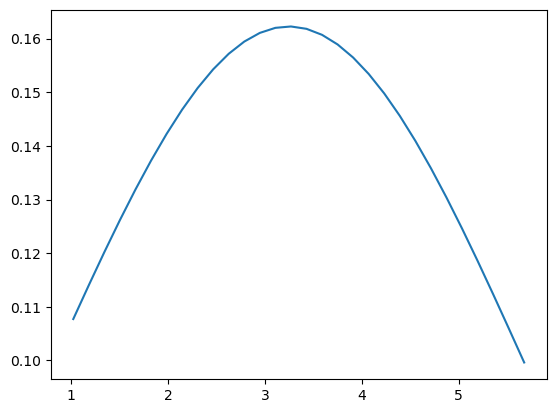

In [334]:
plt.plot(X.detach().numpy(),val.detach().numpy())

In [215]:
Nx=30

In [335]:
X=torch.linspace(boundsMaxMin[0,0],boundsMaxMin[0,1],Nx)
Y=np.linspace(boundsMaxMin[1,0],boundsMaxMin[1,1],Nx)
Z=np.linspace(boundsMaxMin[2,0],boundsMaxMin[2,1],Nx)

In [336]:
g = np.meshgrid(X,Y,Z,indexing='ij')
positions = pd.DataFrame(np.vstack(map(np.ravel, g)).T)
#positions.columns = x_test.columns

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_14325/259279566.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  positions = pd.DataFrame(np.vstack(map(np.ravel, g)).T)


In [221]:
var = scipy.stats.multivariate_normal(mean=(result.x[0:x_train.shape[1]]), cov=np.identity(x_train.shape[1])*result.x[x_train.shape[1]:2*x_train.shape[1]]**2)
val = var.pdf(positions).reshape(Nx,Nx,Nx)

NameError: name 'result' is not defined

In [219]:
plt.plot(X,np.sum(val,axis=(1,2)))
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('a_ventricles')
plt.axvline(x = x_test.iloc[0,0], color = 'r', label = 'axvline - full height')

TypeError: sum() received an invalid combination of arguments - got (out=NoneType, axis=tuple, ), but expected one of:
 * (*, torch.dtype dtype)
      didn't match because some of the keywords were incorrect: out, axis
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [ ]:
x_test

In [ ]:
plt.plot(Y,np.sum(val,axis=(0,2)))
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('a_ventricles')
plt.axvline(x = x_test.iloc[0,1], color = 'r', label = 'axvline - full height')

In [ ]:
plt.plot(Z,np.sum(val,axis=(1,0)))
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('a_ventricles')
plt.axvline(x = x_test.iloc[0,2], color = 'r', label = 'axvline - full height')

In [ ]:
likelihood = np.exp(np.sum(emulator.ensemble_log_likelihood_obs_error(positions,y_test,obs_error),axis=0)).reshape(Nx,Nx,Nx)#Generate likelihood from GP

In [ ]:
val_prior = var_prior.pdf(positions).reshape(Nx,Nx,Nx)

In [ ]:
posterior=(likelihood*val_prior)/(np.sum(likelihood*val_prior)*())

In [ ]:
plt.plot(X,np.sum(posterior,axis=(1,0)))

In [ ]:
np.sum(np.sum(emulator.ensemble_log_likelihood_obs_error(positions,y_test,obs_error),axis=0).reshape(Nx,Nx,Nx),axis=(0,1))

In [ ]:
emulator.ensemble_log_likelihood_obs_error(positions,y_test,obs_error)

In [512]:
y_test

tensor([[152.5960,  83.8327]], dtype=torch.float64)

In [513]:
y_test.shape

torch.Size([1, 2])